# Qt Petrophysical Workflow – Executive Summary & Technical Overview

![Qt](Qt_workflow.png)


## Executive Summary

This application implements a **Qt (PySide6)–based petrophysical workflow** that integrates multi‑run LAS data, parameterized saturation models, and interactive visualization into a single, reproducible system. The core design principle is simple but powerful:

> **All computations write into a single authoritative table (`state.analysis_df`), and all visualizations read from it.**

This guarantees consistency between calculations, plots, and exported parameters, while allowing iterative re‑computation as the user adjusts assumptions (Rw, m, n, Vsh model, etc.).

The workflow currently supports:

- Computation of a Neutron-Density Chartbook Porosity
- Compute Shale Volume from multiple shale indicators using Hodges-Lehman for the final Vsh
- Standard (Pickett/Archie‑style) saturation products
- Waxman–Smits saturation with physically consistent porosity partitioning
- Composite porosity/water visualization using PyQtGraph fill tracks
- Persistent parameter export (`Pickett.txt`) for reproducibility and tracking of parameters

---

## High‑Level Architecture

### Core Objects

- **`WorkflowController`**  
  Orchestrates computation and visualization refresh. Owns the active `state`.

- **`state`**  
  A lightweight container holding:
  - `analysis_df` – the master DataFrame of all curves (measured + derived)
  - `params` – the current parameter dictionary driven by the UI

- **UI Panels**
  - Compute panels (SW / WS tabs)
  - `PlotsPanel` (depth tracks and crossplots)

---

## Data Flow (Authoritative Pattern)

1. **Load / Merge LAS runs**  
   → populate `state.analysis_df`

2. **Resolve curve families**  
   (RT, PHIT, CBW, VSH, etc.) to actual mnemonics

3. **Compute products**  
   - Write *only* into `analysis_df`
   - Never compute directly inside plotting code

4. **Sync UI**  
   - `rebuild_view()` ensures widgets reference the latest DataFrame
   - `update_plots()` / `refresh_plots()` redraw tracks

This separation is what makes the system stable and extensible.

---

## Saturation Workflows

### 1) Standard SW (Pickett‑Style)

Triggered by:
```python
_on_compute_sw_clicked()
```

**Purpose**
- Compute Archie/Pickett‑style saturation and bulk volumes

**Typical outputs written to `analysis_df`:**
- `SWT`, `BVW`, `BVO`
- `MSTAR_FIT`, `MSTAR_APP`

These products are typically used for quick QC and chartbook‑style analysis.

---

### 2) Waxman–Smits (WS) Workflow

Triggered by:
```python
_on_compute_ws_clicked()
```

**Purpose**
- Compute Waxman–Smits saturation
- Partition porosity into physically meaningful components

**Key derived curves:**
- `SW_CP` – Waxman–Smits water saturation
- `BVWT_CP = PHIT * SW_CP`
- `BVWe_CP = max(BVWT_CP − CBW, 0)`
- `PHIE = max(PHIT − CBW, 0)`

**Important constraints**
- `PHIT` is clamped ≥ 0 before use
- `PHIE ≤ PHIT` enforced only after PHIT is non‑negative

---

## Qv and B (Physical Implementation)

### Qv (Hill–Shirley–Klein)

When `Swb` is available, Qv is computed as:

\[
Q_v = \frac{S_{wb}}{0.6425 / \sqrt{\rho_f \cdot SAL} + 0.22}
\]

- Requires `Swb`, `SAL`, and fluid density
- If `Swb` is missing, Qv falls back to zero (Archie‑like behavior)

### B (Bdacy)

- Computed from temperature and Rw using the **Bdacy correlation**
- Reduced to a **single scalar** (median) for Waxman–Smits

This ensures B is consistent and stable across the interval.

---

## Track‑Based Visualization

### Track Keys vs Curve Names (Critical Concept)

- **Track keys** (e.g. `"bvw"`) identify a plot area
- **Curve names** (e.g. `"PHIE"`) are data columns

Confusing the two leads to `KeyError` and empty tracks.

---

### Track 5 – Porosity & Water Partition (Composite Fill Track)

This track intentionally **does not use NMR**. It visualizes the Waxman–Smits porosity system:

| Region | Meaning |
|------|--------|
| PHIT → PHIE | Bound water porosity (CBW) |
| PHIE → BVWe | Effective bulk water |
| BVWe → 0 | Remaining effective pore volume |

Implemented using `FillBetweenItem` in PyQtGraph.

**Key rule:** composite tracks must *not* be indiscriminately cleared with `PlotItem.clear()` after plotting.

---

## UI Parameter Handling (Why Defaults Were Written)

Qt widgets do **not commit typed values** until focus changes.

### Fixes implemented

1. **Live synchronization**
   ```python
   spin.valueChanged.connect(lambda v: params[key] = v)
   ```

2. **Forced commit before compute/export**
   ```python
   spin.interpretText()
   ```

This guarantees `Pickett.txt` always reflects what the user sees.

---

## Parameter Export (Reproducibility)

At WS compute time, constants are written to:

```
./data/parameters/Pickett.txt
```

Contents include:
- `m_cem`
- `n_sat`
- `Rw`
- `mslope`
- `Bdacy`

This creates a durable record of assumptions used to generate results.

---

## Common Pitfalls and Lessons Learned

- **Empty tracks** → caused by clearing after plotting
- **Missing legends** → `addLegend()` must be called explicitly
- **Dark fills** → use RGBA brushes with low alpha
- **Dashed Rt** → set pen style (`Qt.DashLine`)
- **Qv = 0 everywhere** → `Swb` missing
- **Negative PHIE** → PHIT must be clamped before enforcing PHIE ≤ PHIT

---

## Design Philosophy (Why This Works)

- Single source of truth (`analysis_df`)
- Strict separation of compute vs display
- Physically interpretable saturation partitioning
- Parameter persistence for auditability

This architecture mirrors professional petrophysical platforms while remaining transparent, extensible, and reproducible.

---





| Component | File / Module | Responsibility |
|---------|---------------|----------------|
| App entry | apps/merge_gui/main.py | Launch application |
| Main window | ui_main_window.py | Build UI, docks, tabs |
| Controller | workflow_controller.py | Own state, trigger refresh |
| State | state object | analysis_df + params |
| Plotting | plots_panel.py | Depth tracks, fills, legends |
| SW compute | *_panel.py | Pickett-style saturation |
| WS compute | *_panel.py | Waxman–Smits saturation |
| Math utils | utils / models | compute_sw_products, waxsmits_it |
| Export | utils | write Pickett.txt |





## **run the process:**

## *python -m apps.merge_gui.main*

---
---

## main.py

### ./apps/merge_gui/main.py

>>> LOADING ui_main_window.py <<<
>>> LOADING state.py from: /Users/craig/Documents/petro_suite4/petrocore/workflow/state.py
>>> LOADING depth_panel.py from: /Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/depth_panel.py
>>> LOADING plots_panel.py from: /Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py


2026-02-14 12:52:30.278 python[30377:40516996] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'



=== CURVE AUDIT ===
Columns: 73
Rt present: ['AT90', 'AF90']
NMR present: ['PHIT_NMR', 'PHIE_NMR', 'TCMR', 'CMRP_3MS', 'CBW', 'FFI', 'BVIE']

=== RESOLVED FAMILY CURVES (key) ===
RT    -> AT90
TCMR  -> PHIT_NMR
CMRP  -> PHIE_NMR
CBW   -> CBW
FFI   -> FFI
BVIE  -> BVIE


/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:939: RuntimeWarning: All-NaN slice encountered
  hl = np.nanmedian(P, axis=0)
/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:939: RuntimeWarning: All-NaN slice encountered
  hl = np.nanmedian(P, axis=0)
/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:939: RuntimeWarning: All-NaN slice encountered
  hl = np.nanmedian(P, axis=0)
/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:939: RuntimeWarning: All-NaN slice encountered
  hl = np.nanmedian(P, axis=0)
/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:939: RuntimeWarning: All-NaN slice encountered
  hl = np.nanmedian(P, axis=0)
/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:939: RuntimeWarning: All-NaN slice encountered
  hl = np.nanmedian(P, axis=0)
/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:

[VSH] gamma used -> HCGR
[VSH_HL] candidates: ['VSH_GR', 'VSH_ND', 'VSH_DT']
[VSH_HL] usable (finite): ['VSH_GR', 'VSH_ND', 'VSH_DT']


/Users/craig/Documents/petro_suite4/apps/merge_gui/ui_panels/plots_panel.py:1019: RuntimeWarning: All-NaN slice encountered
  df["VSH_HL"] = np.nanmedian(P, axis=0)


Swb range: 0.0 1.0
[WS] Using B (Bdacy median) = 12.19
[PARAMS] Constants written to apps/merge_gui/data/Pickett.txt
PHIT range: 0.0 0.39249174899286016
PHIE range: 0.0 0.37598301788820165
CBW range: 0.0 0.06637991111111113
BVWT_CP range: 1.947638390166101e-05 0.17975388264934825
BVWe_CP range: 0.0 0.16789196642402326
MSTAR range: 2.0 2.9482844444444445
Qv range: 0.0 4.541320741230485


SystemExit: 0

/Users/craig/miniforge3/envs/petro/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


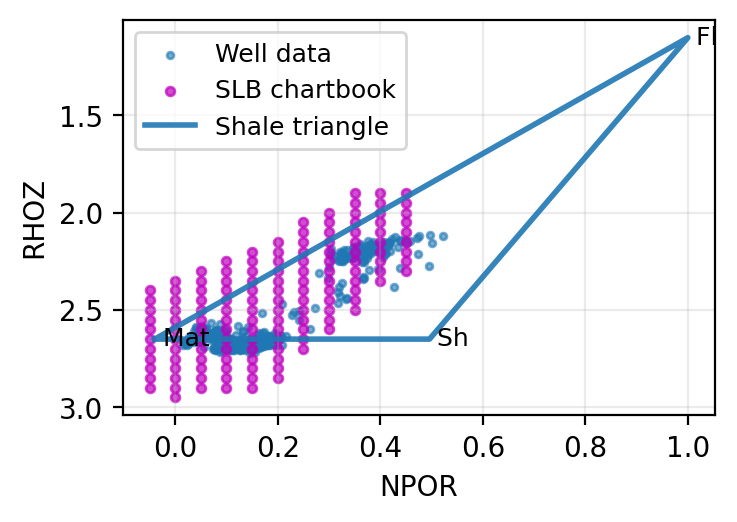

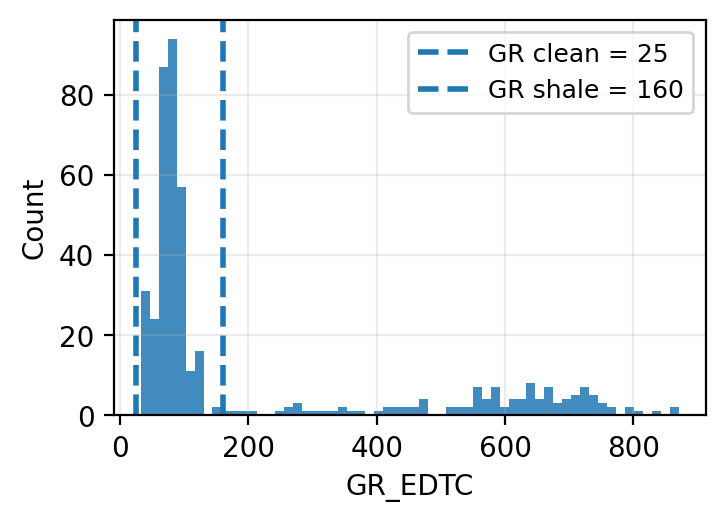

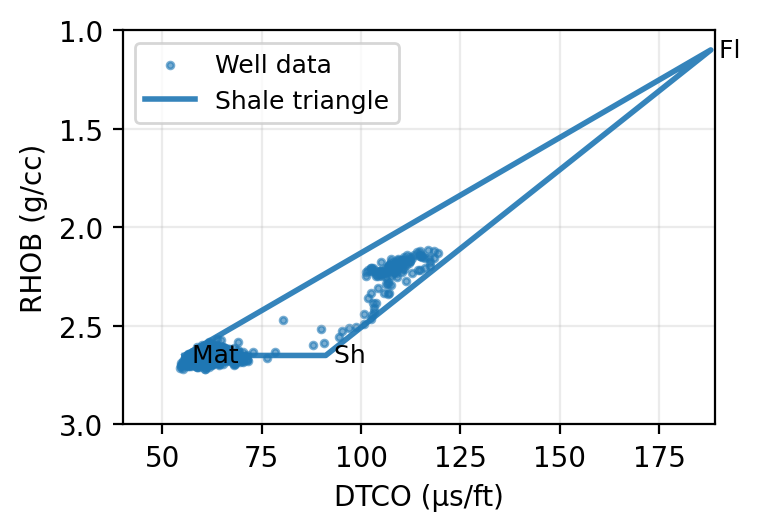

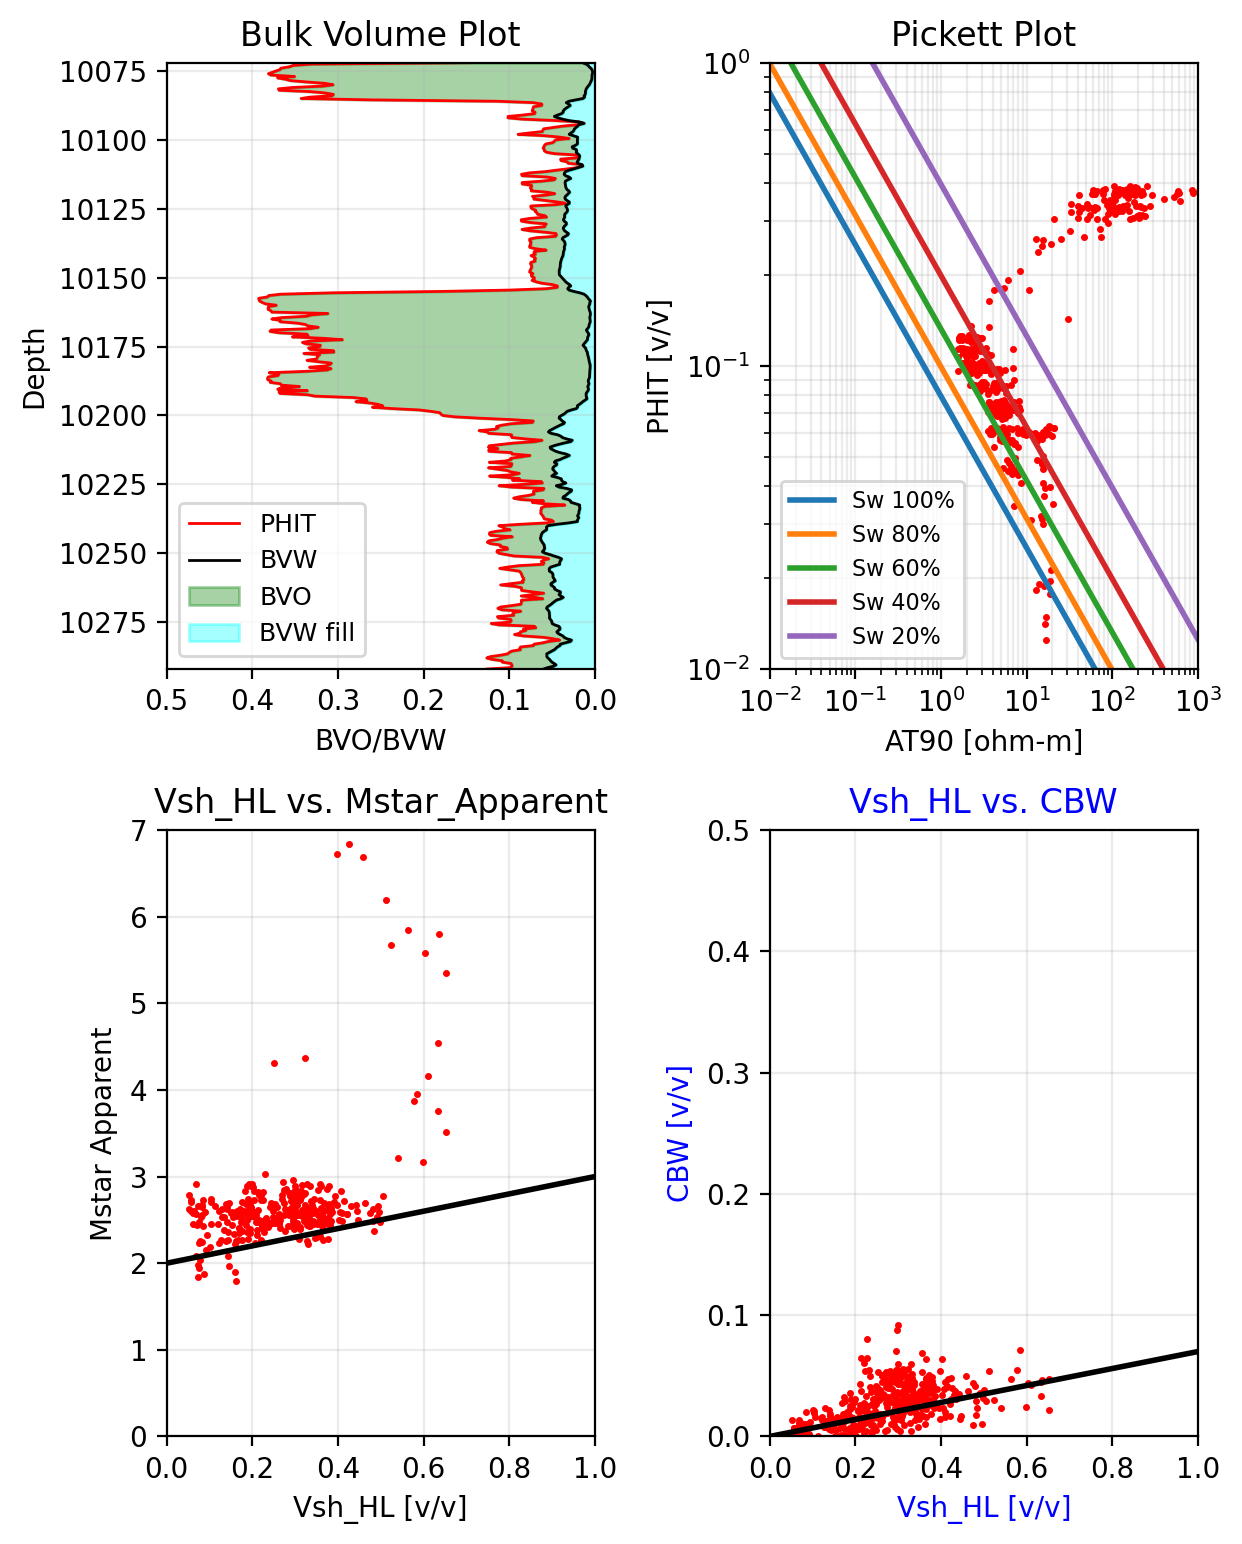

In [1]:
from __future__ import annotations

import os
import sys
from PySide6.QtWidgets import QApplication

MERGED_LAS = "/Users/craig/Documents/petro_suite2/data/outputs/merged/Merged_Well_Log_Bakken_Bakken_renamed.las"




def main():
    import sys
    from PySide6.QtWidgets import QApplication
    from apps.merge_gui.ui_main_window import MainWindow

    app = QApplication(sys.argv)

    w = MainWindow()
    w.show()

    sys.exit(app.exec())


if __name__ == "__main__":
    main()




## state.py

### ./petrocore/workflow/state.py

In [ ]:
from __future__ import annotations

print(">>> LOADING state.py from:", __file__)


from dataclasses import dataclass, field
from typing import Optional, Dict, Any, Tuple

import pandas as pd
from petrocore.models.dataset import Dataset


@dataclass
class WorkflowState:
    # -------------------------
    # Data sources (one or both may be used)
    # -------------------------
    dataset: Optional[Dataset] = None               # preferred (for workflow)
    merged_df: Optional[pd.DataFrame] = None        # optional (merge/QC legacy)

    # -------------------------
    # Active working frame
    # -------------------------
    analysis_df: Optional[pd.DataFrame] = None      # what PlotsPanel reads

    # -------------------------
    # Depth / ZOI
    # -------------------------
    depth_limits: Optional[Tuple[float, float]] = None
    zoi_depth_range: Optional[Tuple[float, float]] = None

    # -------------------------
    # Workflow config + execution
    # -------------------------
    params: Dict[str, Any] = field(default_factory=dict)
    enabled_steps: Dict[str, bool] = field(default_factory=dict)
    registry: Any = None

    # -------------------------
    # Tops overlays (optional)
    # -------------------------
    tops_df: pd.DataFrame = field(
        default_factory=lambda: pd.DataFrame(columns=["Name", "Depth", "Color"])
    )

    # -------------------------
    # UI helpers
    # -------------------------
    plot_title: str = ""


## plots_panel.py

### ./apps/merge_gui/ui_panels/plots_panel.py

**python -m apps.merge_gui.main**

In [ ]:




# apps/merge_gui/ui_panels/plots_panel.py
from __future__ import annotations

print(">>> LOADING plots_panel.py from:", __file__)

import numpy as np
import pandas as pd
import pyqtgraph as pg

from PySide6.QtCore import Qt, QSettings, QTimer, Signal
from PySide6.QtWidgets import (
    QLabel,
    QSizePolicy,
    QSlider,
    QMessageBox,
    QFileDialog,
    QWidget,
    QVBoxLayout,
    QHBoxLayout,
    QTabWidget,
    QFormLayout,
    QPushButton,
    QDoubleSpinBox,
    QSpinBox,
    QGridLayout,   # ✅ add this
)




import matplotlib.pyplot as plt
from matplotlib.backends.backend_qtagg import FigureCanvasQTAgg as FigureCanvas


# =============================================================================
# Small utilities
# =============================================================================
def compute_sal_kppm_from_rw75(Rw75):
    """
    SAL in KPPM from your equation:
      SAL = (10**((3.562 - log10(Rw75 - 0.0123))/0.955))/1000
    """
    Rw75 = np.asarray(Rw75, dtype=float)
    # guard: Rw75 must be > 0.0123 for (Rw75 - 0.0123) > 0
    x = np.clip(Rw75 - 0.0123, 1e-6, None)
    SAL   = (10 ** ((3.562 - np.log10(x)) / 0.955)) / 1000.0
    print("SAL =", SAL)
 
    return SAL


def compute_bdacy(T_F, Rw):
    """
    Bdacy from SCA2006-29 (3) formula you pasted:
      Bdacy = (1-0.83*exp(-exp(-2.38+(42.17/TC))/Rw))*(-3.16+1.59*log(TC))**2
    """
    Rw = np.asarray(Rw, dtype=float)
    TC = (float(T_F) - 32.0) / 1.8

    # guards
    TC_safe = max(TC, 1e-6)
    Rw_safe = np.clip(Rw, 1e-6, None)

    term1 = (1.0 - 0.83 * np.exp(-np.exp(-2.38 + (42.17 / TC_safe)) / Rw_safe))
    term2 = (-3.16 + 1.59 * np.log(TC_safe)) ** 2
    return term1 * term2


def recompute_qv_mstar_b(df, *, rw_source, T_F=150.0, den_fl=1.1, mslope=1.0, m_cem=2.0):
    """
    rw_source can be:
      - column name in df (e.g. 'Rw')
      - or a scalar float
    Writes: SAL, Bdacy, Qv, MSTAR into df (where inputs exist).
    """
    # --- Rw
    if isinstance(rw_source, str):
        if rw_source not in df.columns:
            raise KeyError(f"Rw column '{rw_source}' not found in df")
        Rw = pd.to_numeric(df[rw_source], errors="coerce").to_numpy(float)
    else:
        Rw = np.full(len(df), float(rw_source), dtype=float)

    Rw = np.clip(Rw, 1e-6, None)

    # --- temperature transform
    T_F = float(T_F)
    Rw75 = ((T_F + 6.77) * Rw) / (75.0 + 6.77)

    # --- SAL (KPPM)
    SAL = compute_sal_kppm_from_rw75(Rw75)

    # --- Bdacy (your B)
    Bdacy = compute_bdacy(T_F, Rw)

    # --- Qv from Swb (Hill, Shirley, Klein)
    # Qv = Swb / (0.6425 / sqrt(den_fl * SAL) + 0.22)
    if "Swb" in df.columns:
        Swb = pd.to_numeric(df["Swb"], errors="coerce").to_numpy(float)
        den_fl = float(den_fl)
        denom = (0.6425 / np.sqrt(np.clip(den_fl * SAL, 1e-12, None)) + 0.22)
        Qv = (Swb / denom)
        
        # If Qv = 0 is actually missing shale info, NOT clean sand
        df.loc[df["Qv"] <= 0, "Qv"] = np.nan
        
        ##########Qv = np.clip(Qv, 0.0, 5.0)
        df["Qv"] = Qv
    else:
        # if no Swb, you can still store SAL/Bdacy/MSTAR
        pass

    # --- MSTAR from VSH_HL
    if "VSH_HL" in df.columns:
        Vsh = pd.to_numeric(df["VSH_HL"], errors="coerce").to_numpy(float)
        df["MSTAR"] = Vsh * float(mslope) + float(m_cem)

    # store brine terms for QC
    df["SAL"] = SAL
    df["Bdacy"] = Bdacy

    return df


from pathlib import Path

def write_constants_to_file(file_path, *, m_cem, n_sat, Rw, mslope, Bdacy):
    """
    Write Pickett / saturation constants to a text file.
    """
    try:
        file_path = Path(file_path)
        file_path.parent.mkdir(parents=True, exist_ok=True)

        with open(file_path, "w") as f:
            f.write("# Pickett / Saturation Parameters\n")
            f.write("# -------------------------------\n")
            f.write(f"m_cem  : {m_cem:.3f}\n")
            f.write(f"n_sat  : {n_sat:.3f}\n")
            f.write(f"Rw     : {Rw:.5f}\n")
            f.write(f"mslope : {mslope:.3f}\n")
            f.write(f"Bdacy  : {Bdacy:.4f}\n")

        print(f"[PARAMS] Constants written to {file_path}")

    except Exception as e:
        print(f"[PARAMS] Error writing constants: {e}")


def _first_present(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None


def first_present(cols, candidates):
    return _first_present(cols, candidates)


def make_dspin_old(minv, maxv, step, decimals, value):
    sb = QDoubleSpinBox()
    #sb= QSlider()
    sb.setRange(minv, maxv)
    sb.setSingleStep(step)
    sb.setDecimals(decimals)
    try:
        sb.setValue(float(value))
    except Exception:
        sb.setValue(float(minv))
    return sb


def make_dspin(minv, maxv, step, decimals, value, *, keyboard_tracking=False):
    sb = QDoubleSpinBox()
    #sb = QSlider()
    sb.setRange(minv, maxv)
    sb.setSingleStep(step)
    sb.setDecimals(decimals)

    # Key behavior: don’t leave half-typed values hanging
    sb.setKeyboardTracking(keyboard_tracking)  # False = updates on commit (Enter/focus-out)

    # Optional: nicer typing
    sb.setAccelerated(True)

    try:
        sb.setValue(float(value))
    except Exception:
        sb.setValue(float(minv))

    return sb




def make_ispin(minv, maxv, step, value):
    #sb = QSpinBox()
    sb = QSlider()
    sb.setRange(minv, maxv)
    sb.setSingleStep(step)
    try:
        sb.setValue(int(value))
    except Exception:
        sb.setValue(int(minv))
    return sb




def make_fslider(min_val, max_val, step, decimals, value):
    from PySide6.QtWidgets import QWidget, QHBoxLayout, QLabel, QSlider, QSizePolicy
    from PySide6.QtCore import Qt

    scale = 10 ** int(decimals)

    s = QSlider(Qt.Horizontal)

    s.setMinimum(int(round(min_val * scale)))
    s.setMaximum(int(round(max_val * scale)))
    s.setSingleStep(max(1, int(round(step * scale))))
    s.setPageStep(int(round((max_val - min_val) * scale / 50)))

    # CRITICAL: allow expansion
    s.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)

    lab = QLabel(f"{value:.{decimals}f}")
    lab.setFixedWidth(60)

    w = QWidget()
    h = QHBoxLayout(w)
    h.setContentsMargins(0, 0, 0, 0)

    # CRITICAL: container expands
    w.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)

    h.addWidget(s, stretch=1)
    h.addWidget(lab, stretch=0)

    s.valueChanged.connect(lambda v: lab.setText(f"{v/scale:.{decimals}f}"))

    return w, s, scale

# =============================================================================
# Professional float slider classes
# =============================================================================

from PySide6.QtCore import Qt, Signal, QEvent
from PySide6.QtWidgets import (
    QWidget, QHBoxLayout, QLabel, QSlider, QInputDialog, QSizePolicy
)


class FloatSlider(QSlider):
    """Mac trackpad-friendly slider with SHIFT fine control."""
    def __init__(self, orientation, parent=None):
        super().__init__(orientation, parent)
        self._fine_div = 10  # SHIFT => 10x finer

    def wheelEvent(self, e):
        # angleDelta works for mouse wheels; pixelDelta often used by trackpads on macOS
        delta = e.angleDelta().y()
        if delta == 0:
            delta = e.pixelDelta().y()

        if delta == 0:
            return

        step = self.singleStep()
        if e.modifiers() & Qt.ShiftModifier:
            step = max(1, step // self._fine_div)

        direction = 1 if delta > 0 else -1
        self.setValue(self.value() + direction * step)
        e.accept()


class FloatSliderRow(QWidget):
    """
    Slider row:
      - Expanding slider + live value label
      - SHIFT + trackpad scroll = fine adjust
      - Double-click on slider OR label = type exact value
    """
    valueChangedFloat = Signal(float)

    def __init__(self, min_val, max_val, step, decimals, value, parent=None, label_width=70):
        super().__init__(parent)

        self.decimals = int(decimals)
        self.scale = 10 ** self.decimals

        self.min_i  = int(round(min_val * self.scale))
        self.max_i  = int(round(max_val * self.scale))
        self.step_i = max(1, int(round(step * self.scale)))

        self.slider = FloatSlider(Qt.Horizontal)
        self.slider.setMinimum(self.min_i)
        self.slider.setMaximum(self.max_i)
        self.slider.setSingleStep(self.step_i)
        self.slider.setPageStep(max(1, (self.max_i - self.min_i) // 50))
        #self.slider.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)

        self.slider.setMinimumWidth(120)
        self.slider.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)


        # NOTE: we use self.label (not self.value_label)
        self.label = QLabel("")
        self.label.setFixedWidth(label_width)

        lay = QHBoxLayout(self)
        lay.setContentsMargins(0, 0, 0, 0)
        lay.addWidget(self.slider, stretch=1)
        lay.addWidget(self.label, stretch=0)

        self.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Fixed)

        # Trackpad-friendly: capture double-clicks even when they land on child widgets
        self.slider.installEventFilter(self)
        self.label.installEventFilter(self)

        self.set_value(value)

        self.slider.valueChanged.connect(self._sync)
        self.slider.valueChanged.connect(lambda _: self.valueChangedFloat.emit(self.value()))

    def eventFilter(self, obj, event):
        # Catch double-click on slider/label and forward to our handler
        if event.type() == QEvent.MouseButtonDblClick:
            self._prompt_value()
            return True
        return super().eventFilter(obj, event)

    def _sync(self, v_i: int):
        self.label.setText(f"{v_i / self.scale:.{self.decimals}f}")

    def value(self) -> float:
        return self.slider.value() / self.scale

    def set_value(self, v: float):
        v_i = int(round(v * self.scale))
        v_i = max(self.min_i, min(self.max_i, v_i))
        self.slider.setValue(v_i)
        self._sync(v_i)

    def _prompt_value(self):
        v0 = self.value()
        v, ok = QInputDialog.getDouble(
            self,
            "Set value",
            "Value:",
            v0,
            self.min_i / self.scale,
            self.max_i / self.scale,
            self.decimals,
        )
        if ok:
            self.set_value(v)
            self.valueChangedFloat.emit(self.value())



def get_col(df: pd.DataFrame, col: str):
    """Return numeric numpy array for df[col] if present; else None."""
    if df is None or col is None:
        return None
    if col not in df.columns:
        return None
    return pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)


def _pretty(k: str) -> str:
    return k.replace("_", " ").title()


def vsh_from_gr(gr, gr_clean=25.0, gr_shale=160.0, clip=True):
    """
    Linear Vsh from gamma ray (GR or CGR) endpoints.
    Returns numpy array, NaN where gr is not finite.
    """
    gr = np.asarray(gr, dtype=float)
    denom = (gr_shale - gr_clean)
    if denom == 0:
        v = np.full_like(gr, np.nan, dtype=float)
    else:
        v = (gr - gr_clean) / denom

    if clip:
        v = np.clip(v, 0.0, 1.0)

    v[~np.isfinite(gr)] = np.nan
    return v


def vsh_from_gamma(df: pd.DataFrame, params: dict):
    """
    Prefer CGR if available, else GR, then compute VSH_GR using vsh_from_gr().
    Returns: (vsh_array or None, gamma_col_used or None)
    """
    # 1) honor curve-picker selections
    gamma_col = params.get("cgr_curve")
    if not gamma_col or gamma_col not in df.columns:
        gamma_col = params.get("gr_curve")

    # 2) fallback list (CGR first)
    if not gamma_col or gamma_col not in df.columns:
        gamma_col = _first_present(df.columns, ["HCGR", "CGR", "ECGR", "GR_EDTC", "HSGR", "GR", "SGR", "HGR"])

    if not gamma_col or gamma_col not in df.columns:
        return None, None

    gr_clean = float(params.get("gr_clean", 25.0))
    gr_shale = float(params.get("gr_shale", 160.0))

    g = pd.to_numeric(df[gamma_col], errors="coerce").to_numpy(float)
    return vsh_from_gr(g, gr_clean=gr_clean, gr_shale=gr_shale, clip=True), gamma_col


def vsh_from_triangle(x, y, A, B, C, clip=True):
    """
    Vsh = barycentric weight of shale vertex B for points (x,y)
    A=matrix, B=shale, C=fluid.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    out = np.full_like(x, np.nan, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    if not np.any(m):
        return out

    Ax, Ay = A
    Bx, By = B
    Cx, Cy = C

    denom = (By - Cy) * (Ax - Cx) + (Cx - Bx) * (Ay - Cy)
    if not np.isfinite(denom) or abs(denom) < 1e-12:
        return out

    # barycentric weight for shale vertex B
    lamB = ((Cy - Ay) * (x[m] - Cx) + (Ax - Cx) * (y[m] - Cy)) / denom
    if clip:
        lamB = np.clip(lamB, 0.0, 1.0)

    out[m] = lamB
    return out


def vsh_from_nd_triangle(df: pd.DataFrame, params: dict):
    """
    VSH from neutron-density triangle using barycentric shale weight.
    Uses params:
      neut_matrix, den_matrix, neut_shale, den_shale, neut_fl, den_fl
    Curve choices:
      tnph_curve, rhob_curve
    """
    tnph = params.get("tnph_curve")
    rhob = params.get("rhob_curve")

    if (not tnph) or (tnph not in df.columns):
        tnph = _first_present(df.columns, ["TNPH", "NPHI", "CNL", "NPOR"])
    if (not rhob) or (rhob not in df.columns):
        rhob = _first_present(df.columns, ["RHOZ", "RHOB"])

    if (tnph is None) or (rhob is None):
        return None

    x = pd.to_numeric(df[tnph], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[rhob], errors="coerce").to_numpy(float)

    A = (float(params.get("neut_matrix", -0.04)), float(params.get("den_matrix", 2.65)))
    B = (float(params.get("neut_shale", 0.49)),   float(params.get("den_shale", 2.65)))
    C = (float(params.get("neut_fl", 1.0)),       float(params.get("den_fl", 1.10)))

    return vsh_from_triangle(x, y, A, B, C, clip=True)


def vsh_from_dt_triangle(df: pd.DataFrame, params: dict):
    """
    VSH from DT-RHOB triangle using barycentric shale weight.
    Uses params:
      dt_matrix, den_matrix, dt_shale, den_shale, dt_fl, den_fl
    Curve choices:
      dtco_curve, rhob_curve
    """
    rhob = params.get("rhob_curve")
    if (not rhob) or (rhob not in df.columns):
        rhob = _first_present(df.columns, ["RHOZ", "RHOB"])

    dtco = params.get("dtco_curve")
    if (not dtco) or (dtco not in df.columns):
        dtco = _first_present(df.columns, ["DTCO", "DTC", "AC"])

    if (rhob is None) or (dtco is None):
        return None

    # x=DT, y=RHOB to match your crossplot axes
    x = pd.to_numeric(df[dtco], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[rhob], errors="coerce").to_numpy(float)

    A = (float(params.get("dt_matrix", 55.5)), float(params.get("den_matrix", 2.65)))
    B = (float(params.get("dt_shale", 90.0)),  float(params.get("den_shale", 2.65)))
    C = (float(params.get("dt_fl", 188.0)),    float(params.get("den_fl", 1.10)))

    return vsh_from_triangle(x, y, A, B, C, clip=True)


def compute_sw_products(
    df: pd.DataFrame,
    rt_col: str,
    phit_col: str,
    qv_col: str | None,
    vsh_col: str | None,
    m_cem: float,
    n_sat: float,
    rw: float,
    mslope: float,
    B: float,
):
    """
    Vectorized SW/BVW/BVO + MSTAR_APP + fitted MSTAR line.
    Returns dict of numpy arrays aligned to df.index.
    """
    rt   = pd.to_numeric(df[rt_col], errors="coerce").to_numpy(float)
    phit = pd.to_numeric(df[phit_col], errors="coerce").to_numpy(float)

    if qv_col and (qv_col in df.columns):
        qv = pd.to_numeric(df[qv_col], errors="coerce").to_numpy(float)
    else:
        qv = np.zeros_like(phit)

    if vsh_col and (vsh_col in df.columns):
        vsh = pd.to_numeric(df[vsh_col], errors="coerce").to_numpy(float)
    else:
        vsh = np.full_like(phit, np.nan)

    n = len(df)
    BVW = np.full(n, np.nan, float)
    SWT = np.full(n, np.nan, float)
    BVO = np.full(n, np.nan, float)
    MSTAR_APP = np.full(n, np.nan, float)
    MSTAR = np.full(n, np.nan, float)

    m = np.isfinite(rt) & np.isfinite(phit) & (rt > 0) & (phit > 0)

    # Archie-style BVW
    BVW_m = phit[m] * ((1.0 / (phit[m] ** m_cem)) * (rw / rt[m])) ** (1.0 / n_sat)
    BVW_m = np.minimum(BVW_m, phit[m])  # clamp BVW <= PHIT

    SWT_m = np.where(phit[m] > 0, BVW_m / phit[m], np.nan)
    BVO_m = phit[m] * (1.0 - SWT_m)

    # Apparent M*:
    # MSTARAPP = log10(rw/(Rt*(1+rw*B*Qv))) / log10(PHIT)
    denom = rt[m] * (1.0 + rw * B * qv[m])
    ok = np.isfinite(denom) & (denom > 0) & np.isfinite(phit[m]) & (phit[m] > 0) & (phit[m] != 1.0)

    ms_app = np.full(np.sum(m), np.nan, float)
    
    ms_app[ok] = np.log10(rw / denom[ok]) / np.log10(phit[m][ok])

    BVW[m] = BVW_m
    SWT[m] = SWT_m
    BVO[m] = BVO_m
    MSTAR_APP[m] = ms_app

    # fitted M* line
    if np.any(np.isfinite(vsh)):
        MSTAR = vsh * mslope + m_cem

    return dict(BVW=BVW, SWT=SWT, BVO=BVO, MSTAR_APP=MSTAR_APP, MSTAR=MSTAR)





def waxsmits_it(Rt, PHIT, MSTAR, Qv, Rw, B, n_sat=2.0, n_steps=100):
    """
    Old WS iterative style:
      sweep swap from 0.01..1.00 until swt_i <= swap, then stop.

    Rt,PHIT,MSTAR,Qv are numpy arrays (float).
    Returns SW (numpy array) clipped to [0..1].
    """
    Rt = np.asarray(Rt, dtype=float)
    PHIT = np.asarray(PHIT, dtype=float)
    MSTAR = np.asarray(MSTAR, dtype=float)
    Qv = np.asarray(Qv, dtype=float)

    n = Rt.size
    out = np.full(n, np.nan, dtype=float)

    # basic finite mask
    m = (
        np.isfinite(Rt) & (Rt > 0) &
        np.isfinite(PHIT) & (PHIT > 0) &
        np.isfinite(MSTAR) &
        np.isfinite(Qv)
    )
    if not np.any(m):
        return out

    # iterate per sample (matches your old logic)
    for k in np.where(m)[0]:
        Rt2 = Rt[k]
        PHIT2 = PHIT[k]
        QV2 = Qv[k]
        MSTAR2 = MSTAR[k]

        swt_i = np.nan
        for i in range(1, n_steps + 1):
            swap = i / n_steps  # 0.01..1.00 if n_steps=100

            denom = Rt2 * (1.0 + Rw * B * QV2 / swap)
            if not np.isfinite(denom) or denom <= 0:
                continue

            inner = ((1.0 / (PHIT2 ** MSTAR2)) * Rw) / denom
            if not np.isfinite(inner) or inner <= 0:
                continue

            swt_i = inner ** (1.0 / float(n_sat))

            # ✅ your "exit" was intended to break
            if swt_i <= swap:
                break

        # clamp like your original
        if not np.isfinite(swt_i):
            continue
        if swt_i > 1.0:
            swt_i = 1.0
        elif swt_i <= 0.0:
            swt_i = 0.0001

        out[k] = swt_i

    return np.clip(out, 0.0, 1.0)





class ParamStore:
    """
    Read/write params from controller.state.params and persist via QSettings.
    """
    def __init__(self, controller, org="petro_suite3", app="merge_gui"):
        self.controller = controller
        self.settings = QSettings(org, app)

    def get(self, key, default=None):
        p = getattr(self.controller.state, "params", None)
        if not isinstance(p, dict):
            self.controller.state.params = {}
            p = self.controller.state.params
        if key in p:
            return p[key]
        return self.settings.value(key, default)

    def set(self, key, value):
        p = getattr(self.controller.state, "params", None)
        if not isinstance(p, dict):
            self.controller.state.params = {}
            p = self.controller.state.params
        p[key] = value
        self.settings.setValue(key, value)



# =============================================================================
# PlotsPanel
# =============================================================================
class PlotsPanel(QWidget):
    def __init__(self, controller):
        super().__init__()
        self.controller = controller
        self.param_store = ParamStore(controller)

        self.tabs = QTabWidget()

        self.settings = QSettings("CrestedButtePetro", "PetroSuite2")
        
        # -------------------------
        # Depth tracks (PyQtGraph)
        # -------------------------
        self.tracks = pg.GraphicsLayoutWidget()
        self.tabs.addTab(self.tracks, "Depth Tracks")
        self.track_items = {}
        self._build_tracks()

        # -------------------------
        # Matplotlib figures/canvases (create ONCE)
        # -------------------------
        self.fig_nd, self.ax_nd = plt.subplots(1, 1, figsize=(6, 6))
        self.canvas_nd = FigureCanvas(self.fig_nd)

        self.fig_gr, self.ax_gr = plt.subplots(1, 1, figsize=(6, 3))
        self.canvas_gr = FigureCanvas(self.fig_gr)

        self.fig_dt, self.ax_dt = plt.subplots(1, 1, figsize=(6, 6))
        self.canvas_dt = FigureCanvas(self.fig_dt)

        # SW tab figure (Matplotlib) 2x2 mosaic
        self.fig_sw = plt.figure(figsize=(11, 7))
        axs = self.fig_sw.subplot_mosaic(
            [
                ["left",   "middle"],
                ["right",  "cbw"   ],
            ]
        )
        self.ax_sw_left  = axs["left"]    # BVW/BVO depth plot
        self.ax_sw_mid   = axs["middle"]  # Pickett
        self.ax_sw_right = axs["right"]   # Vsh vs Mstar
        self.ax_sw_cbw   = axs["cbw"]     # Vsh_HL vs CBW
        self.canvas_sw = FigureCanvas(self.fig_sw)

        # -------------------------
        # Tabs (canvas + controls)
        # -------------------------
        self.tabs.addTab(self._build_crossplots_tab(), "Crossplots + Histogram")
        self.tabs.addTab(self._build_sw_tab(), "Sw / Pickett / M* / CBW")

        layout = QVBoxLayout(self)
        layout.addWidget(self.tabs)
        
        self._sw_recompute_timer = QTimer(self)
        self._sw_recompute_timer.setSingleShot(True)
        self._sw_recompute_timer.timeout.connect(self._on_compute_sw_clicked)

        self._vsh_recompute_timer = QTimer()
        self._vsh_recompute_timer.setSingleShot(True)
        
        def _do_vsh_live_update():
            try:
                if hasattr(self, "_recompute_vsh_only"):
                    self._recompute_vsh_only()
                fn = getattr(self, "_refresh_vsh_depth_plot", None)
                if callable(fn):
                    fn()
            except Exception:
                pass
        
        self._vsh_recompute_timer.timeout.connect(_do_vsh_live_update)



    
    # =============================================================================
    # Public API
    # =============================================================================
    def update_all(self, state):
        self.update_depth_plot(state)
        self.update_nd_crossplot(state)
        self.update_gr_hist(state)
        self.update_dt_rhob_crossplot(state)
        self.update_sw_tab(state)

    # =============================================================================
    # Param update
    # =============================================================================
 
    def _set_param_and_refresh(self, key, value):
        self.param_store.set(key, value)
        # keep state.params in sync with param_store (so live recompute sees slider changes)
        try:
            state = getattr(self.controller, "state", None)
            if state is not None:
                params = getattr(state, "params", None)
                if isinstance(params, dict):
                    params[key] = value
                else:
                    state.params = {key: value}
        except Exception:
            pass


        
    
        # If SW/M* parameters change, recompute derived curves (debounced for sliders)
        if key.startswith("sw.") or key == "cbw_intercept":
            if key in ("sw.rw", "sw.B", "sw.m_cem", "sw.n_sat", "sw.mslope", "cbw_intercept"):
                # debounce recompute to avoid hammering while user drags a slider
                if hasattr(self, "_sw_recompute_timer") and self._sw_recompute_timer is not None:
                    self._sw_recompute_timer.start(150)  # ms
                else:
                    self._on_compute_sw_clicked()
    
        if hasattr(self.controller, "update_plots"):
            self.controller.update_plots()
        else:
            self.controller.refresh_plots()

        # keep the VSH depth plot in sync
        try:
            self._refresh_vsh_depth_plot()
        except Exception:
            pass
    
        # --- keep VSH depth plot in sync (crossplots tab)
        try:
            fn = getattr(self, "_refresh_vsh_depth_plot", None)
            if callable(fn):
                fn()
        except Exception:
            pass


        # --- Live VSH update when adjusting crossplot parameters
        try:
            tabs = getattr(self, "tabs", None)
            on_cross = True
            if tabs is not None:
                tab_name = tabs.tabText(tabs.currentIndex()).strip().lower()
                on_cross = ("cross" in tab_name)

            if on_cross and hasattr(self, "_recompute_vsh_only"):
                self._recompute_vsh_only()

            fn = getattr(self, "_refresh_vsh_depth_plot", None)
            if callable(fn):
                fn()
        except Exception:
            pass






    
    
    def _on_export_df_clicked(self):
    
        state = getattr(self, "state", None)
        if state is None:
            QMessageBox.warning(self, "Export DF", "State object not found.")
            return
    
        # --- Prefer depth-windowed view ---
        df = getattr(state, "analysis_df_view", None)
        if df is None or df.empty:
            df = getattr(state, "analysis_df", None)
    
        if df is None or df.empty:
            QMessageBox.warning(self, "Export DF", "No dataframe available to export.")
            return
    
        # --- Ask where to save ---
        file_name, _ = QFileDialog.getSaveFileName(
            self,
            "Export DataFrame",
            "qt_export.csv",
            "CSV Files (*.csv);;Excel Files (*.xlsx)"
        )
    
        if not file_name:
            return
    
        try:
            out = df.copy()
    
            # Insert depth as first column
            if out.index.name is None:
                out.insert(0, "DEPT", out.index.astype(float))
            else:
                out.insert(0, out.index.name, out.index.astype(float))
    
            if file_name.endswith(".xlsx"):
                out.to_excel(file_name, index=False)
            else:
                out.to_csv(file_name, index=False)
    
            QMessageBox.information(self, "Export DF", f"Saved:\n{file_name}")
    
        except Exception as e:
            QMessageBox.critical(self, "Export DF", str(e))
    

    
    # =============================================================================
    # Buttons
    # =============================================================================

    def _recompute_vsh_only(self):
        """Recompute VSH_GR / VSH_ND / VSH_DT / VSH_HL using current params, no button needed."""
        state = getattr(self.controller, "state", None)
        if state is None:
            return
    
        df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            return
    
        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}
    
        # ---- VSH from Gamma (CGR preferred)
        vsh_gr, gamma_used = vsh_from_gamma(df, params)
        if vsh_gr is not None:
            df["VSH_GR"] = pd.to_numeric(vsh_gr, errors="coerce")
    
        # ---- VSH_ND
        vsh_nd = vsh_from_nd_triangle(df, params)
        if vsh_nd is not None:
            df["VSH_ND"] = pd.to_numeric(vsh_nd, errors="coerce")
    
        # ---- VSH_DT
        vsh_dt = vsh_from_dt_triangle(df, params)
        if vsh_dt is not None:
            df["VSH_DT"] = pd.to_numeric(vsh_dt, errors="coerce")
    
        # ---- HL combine (use finite-only)
        base_cols = [c for c in ["VSH_GR", "VSH_ND", "VSH_DT"] if c in df.columns]
        good_cols = []
        for c in base_cols:
            arr = pd.to_numeric(df[c], errors="coerce").to_numpy(dtype=float)
            if np.isfinite(arr).any():
                good_cols.append(c)
    
        if len(good_cols) == 0:
            hl = np.full(len(df), np.nan, dtype=float)
        elif len(good_cols) == 1:
            hl = pd.to_numeric(df[good_cols[0]], errors="coerce").to_numpy(dtype=float)
        elif len(good_cols) == 2:
            a = pd.to_numeric(df[good_cols[0]], errors="coerce").to_numpy(dtype=float)
            b = pd.to_numeric(df[good_cols[1]], errors="coerce").to_numpy(dtype=float)
            hl = 0.5 * (a + b)
        else:
            a, b, c = (pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float) for col in good_cols[:3])
            P = np.stack([0.5 * (a + b), 0.5 * (a + c), 0.5 * (b + c)], axis=0)
            hl = np.nanmedian(P, axis=0)
    
        hl = np.clip(pd.to_numeric(hl, errors="coerce"), 0.0, 1.0)
        if "VSH_GR" in df.columns:
            hl = pd.Series(hl, index=df.index).fillna(pd.to_numeric(df["VSH_GR"], errors="coerce")).to_numpy(dtype=float)
    
        df["VSH_HL"] = hl
    
        # write back
        state.analysis_df = df
    
        # keep view in sync (if you have a separate view df)
        dfV = getattr(state, "analysis_df_view", None)
        if dfV is not None and not dfV.empty:
            vsh_cols = [c for c in df.columns if "VSH" in c.upper()]
            for c in vsh_cols:
                dfV[c] = pd.to_numeric(df[c], errors="coerce").reindex(dfV.index)
            state.analysis_df_view = dfV
    


    def _on_compute_vsh_clicked(self):
        state = getattr(self.controller, "state", None)
        if state is None:
            return
    
        df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            return
    
        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}
    
        # ---- VSH from Gamma (CGR preferred)
        vsh_gr, gamma_used = vsh_from_gamma(df, params)
        if vsh_gr is not None:
            df["VSH_GR"] = pd.to_numeric(vsh_gr, errors="coerce")
            print(f"[VSH] gamma used -> {gamma_used}")
        else:
            # ensure column doesn't linger from a previous run
            if "VSH_GR" in df.columns:
                df["VSH_GR"] = pd.to_numeric(df["VSH_GR"], errors="coerce")
    
        # ---- VSH_ND (only if TNPH + RHOB exist)
        vsh_nd = vsh_from_nd_triangle(df, params)
        if vsh_nd is not None:
            df["VSH_ND"] = pd.to_numeric(vsh_nd, errors="coerce")
    
        # ---- VSH_DT (only if RHOB + DT exist)
        vsh_dt = vsh_from_dt_triangle(df, params)
        if vsh_dt is not None:
            df["VSH_DT"] = pd.to_numeric(vsh_dt, errors="coerce")
    
        # ---- Robust HL combine (median of pairwise averages), but only using usable curves
        base_cols = [c for c in ["VSH_GR", "VSH_ND", "VSH_DT"] if c in df.columns]
    
        good_cols = []
        for c in base_cols:
            arr = pd.to_numeric(df[c], errors="coerce").to_numpy(dtype=float)
            if np.isfinite(arr).any():
                good_cols.append(c)
    
        print("[VSH_HL] candidates:", base_cols)
        print("[VSH_HL] usable (finite):", good_cols)
    
        if len(good_cols) == 0:
            df["VSH_HL"] = np.nan
    
        elif len(good_cols) == 1:
            df["VSH_HL"] = pd.to_numeric(df[good_cols[0]], errors="coerce").to_numpy(dtype=float)
    
        elif len(good_cols) == 2:
            a = pd.to_numeric(df[good_cols[0]], errors="coerce").to_numpy(dtype=float)
            b = pd.to_numeric(df[good_cols[1]], errors="coerce").to_numpy(dtype=float)
            df["VSH_HL"] = 0.5 * (a + b)
    
        else:
            a, b, c = (pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float) for col in good_cols[:3])
            P = np.stack([0.5 * (a + b), 0.5 * (a + c), 0.5 * (b + c)], axis=0)
            df["VSH_HL"] = np.nanmedian(P, axis=0)
    
        # clip to [0,1]
        df["VSH_HL"] = np.clip(pd.to_numeric(df["VSH_HL"], errors="coerce").to_numpy(dtype=float), 0.0, 1.0)
    
        # fill remaining NaNs from GR if available
        if "VSH_GR" in df.columns:
            df["VSH_HL"] = pd.Series(df["VSH_HL"], index=df.index).fillna(
                pd.to_numeric(df["VSH_GR"], errors="coerce")
            ).to_numpy(dtype=float)
    
        # ---- write back
        state.analysis_df = df
    
        # ---- ensure view gets the new columns BEFORE plotting
        try:
            if hasattr(self.controller, "rebuild_view"):
                self.controller.rebuild_view()
        except Exception:
            pass
    
        # If your app keeps a separate df view object, mirror VSH columns into it
        try:
            dfA = getattr(state, "analysis_df", None)
            dfV = getattr(state, "analysis_df_view", None)
            if dfA is not None and dfV is not None and not dfV.empty:
                vsh_cols = [c for c in dfA.columns if "VSH" in c.upper()]
                for c in vsh_cols:
                    dfV[c] = pd.to_numeric(dfA[c], errors="coerce").reindex(dfV.index)
                state.analysis_df_view = dfV
        except Exception:
            pass
    
        # ---- refresh UI plots
        try:
            self.controller.refresh_plots()
        except Exception:
            pass
    
        # ---- refresh VSH depth plot (single call)
        try:
            fn = getattr(self, "_refresh_vsh_depth_plot", None)
            if callable(fn):
                fn()
        except Exception:
            pass




    
    def _on_compute_sw_clicked(self):
        w = self.focusWidget()
        if w is not None:
            try:
                w.clearFocus()
            except Exception:
                pass

        state = getattr(self.controller, "state", None)
        if state is None:
            return

        df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            return

        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}

        # --- Resolve Rt curve
        rt_col = params.get("rt_curve")
        if (not rt_col) or (rt_col not in df.columns):
            rt_col = _first_present(df.columns, ["AT90", "AF90", "AO90", "ILD", "RT"])

        # --- Resolve PHIT curve (allow chartbook/nmr fallback)
        phit_col = params.get("phit_curve")
        if (not phit_col) or (phit_col not in df.columns):
            phit_col = "PHIT" if "PHIT" in df.columns else _first_present(df.columns, ["PHIT_CHART", "PHIT_NMR", "TCMR", "MPHIS"])

        if (rt_col is None) or (phit_col is None):
            print("[SW] Need Rt + PHIT (or PHIT_CHART/PHIT_NMR) to compute SW/BVW/M*")
            return

        # --- Optional Qv
        qv_col = "Qv" if "Qv" in df.columns else ("QV" if "QV" in df.columns else None)

        # --- Parameters
        m_cem  = float(params.get("sw.m_cem", 2.0))
        n_sat  = float(params.get("sw.n_sat", 2.0))
        rw     = float(params.get("sw.rw", 0.03))
        mslope = float(params.get("sw.mslope", 1.0))
        B      = float(params.get("sw.B", 0.0))

        # Vsh column for fitted M*
        vsh_col = "VSH_HL" if "VSH_HL" in df.columns else None

        out = compute_sw_products(
            df=df,
            rt_col=rt_col,
            phit_col=phit_col,
            qv_col=qv_col,
            vsh_col=vsh_col,
            m_cem=m_cem,
            n_sat=n_sat,
            rw=rw,
            mslope=mslope,
            B=B,
        )

        df["PHIT_USED"] = pd.to_numeric(df[phit_col], errors="coerce")  # debug
        df["BVW"] = out["BVW"]
        df["SWT"] = out["SWT"]
        df["BVO"] = out["BVO"]
        df["MSTAR_APP"] = out["MSTAR_APP"]
        df["MSTAR_FIT"] = out["MSTAR"]

        state.analysis_df = df
        if hasattr(self.controller, "rebuild_view"):
            self.controller.rebuild_view()
        self.controller.refresh_plots()


    def _on_compute_ws_clicked(self):
        # Ensure any active editor commits its text to the widget value
        w = self.focusWidget()
        if w is not None:
            try:
                w.clearFocus()
            except Exception:
                pass

        state = getattr(self.controller, "state", None)
        if state is None:
            return
    
        df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            return
    
        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}
    
        # --- Resolve Rt
        rt_col = params.get("rt_curve")
        if (not rt_col) or (rt_col not in df.columns):
            for c in ["AT90", "AF90", "ILD", "RT"]:
                if c in df.columns:
                    rt_col = c
                    break
        if rt_col is None:
            print("[WS] No Rt curve found")
            return
    
        # --- Resolve PHIT
        phit_col = params.get("phit_curve")
        if (not phit_col) or (phit_col not in df.columns):
            if "PHIT" in df.columns:
                phit_col = "PHIT"
            else:
                for c in ["PHIT_CHART", "PHIT_NMR", "TCMR", "MPHIS"]:
                    if c in df.columns:
                        phit_col = c
                        break
        if phit_col is None:
            print("[WS] No PHIT curve found")
            return
    
        # Standardize PHIT
        if phit_col != "PHIT":
            df["PHIT"] = pd.to_numeric(df[phit_col], errors="coerce")
            phit_col = "PHIT"
    
        # --- Resolve Qv (optional; if missing -> 0)
        qv_col = "Qv" if "Qv" in df.columns else ("QV" if "QV" in df.columns else None)


        # --- VSH required
        vsh_col = "VSH_HL" if "VSH_HL" in df.columns else None
        if vsh_col is None:
            print("[WS] Need VSH_HL (compute Vsh first) to build CBWapp and MSTAR for Waxman-Smits")
            return
        
        # --- CBW_Int from SW-tab param "cbw_intercept"
        CBW_Int = float(params.get("cbw_intercept", 0.15))  # <-- uses your existing UI key
        Vsh = pd.to_numeric(df[vsh_col], errors="coerce").to_numpy(float)
        Vsh = np.clip(Vsh, 0.0, 1.0)
        
        df["CBWapp"] = np.clip(Vsh * CBW_Int, 0.0, 1.0)
        cbw = "CBWapp"
       
        # --- Params
        m_cem  = float(params.get("sw.m_cem", 2.0))     # intercept
        n_sat  = float(params.get("sw.n_sat", 2.0))     # saturation exponent
        rw     = float(params.get("sw.rw", 0.03))
        B      = float(params.get("sw.B", 0.0))
        mslope = float(params.get("sw.mslope", 1.0))    # M* slope vs Vsh

        # --- recompute SAL, Qv (Hill/Shirley/Klein), and B (Bdacy) because Rw can vary
        T_F    = float(params.get("sw.T_F", 150.0))
        den_fl = float(params.get("sw.den_fl", 1.0))
        
        # Rw can be a curve in df or a scalar param
        rw_curve = params.get("sw.rw_curve", None)
        if isinstance(rw_curve, str) and rw_curve in df.columns:
            Rw_arr = pd.to_numeric(df[rw_curve], errors="coerce").to_numpy(float)
            Rw_arr = np.where(np.isfinite(Rw_arr), Rw_arr, rw)  # fall back to scalar rw where missing
        else:
            Rw_arr = np.full(len(df), rw, dtype=float)
        
        Rw_arr = np.clip(Rw_arr, 1e-6, None)
        
        # Rw75
        Rw75 = ((T_F + 6.77) * Rw_arr) / (75.0 + 6.77)
        
        # SAL (KPPM)
        x = np.clip(Rw75 - 0.0123, 1e-6, None)
        SAL = (10 ** ((3.562 - np.log10(x)) / 0.955)) / 1000.0
        df["SAL"] = SAL


        # Ensure PHIT is sane for ratios
        PHIT = pd.to_numeric(df[phit_col], errors="coerce").to_numpy(dtype=float)
        
        # If CBWapp was computed earlier as an array, use that array directly.
        # If you stored it in df, coerce it like this:
        cbw = pd.to_numeric(df["CBWapp"], errors="coerce").to_numpy(dtype=float)
        
        PHIT = np.clip(PHIT, 0.0, None)
        cbw  = np.clip(cbw,  0.0, None)
        
        PHIT_safe = np.clip(PHIT, 1e-6, None)
        Swb = np.clip(cbw / PHIT_safe, 0.0, 1.0)
        df["Swb"] = Swb

        print("Swb range:", np.nanmin(Swb), np.nanmax(Swb))
  
        
        # Qv from Swb (Hill, Shirley & Klein)
        if "Swb" in df.columns:
            Swb = pd.to_numeric(df["Swb"], errors="coerce").to_numpy(float)
            denom = (0.6425 / np.sqrt(np.clip(den_fl * SAL, 1e-12, None)) + 0.22)
            df["Qv"] = np.clip(Swb / denom, 0.0, 5.0)
            qv_col = "Qv"
        else:
            print("[WS] Swb missing -> cannot compute Qv from HSK; using existing Qv/0")
        
        # Bdacy array
        TC = (T_F - 32.0) / 1.8
        TC = max(TC, 1e-6)
        term1 = (1.0 - 0.83 * np.exp(-np.exp(-2.38 + (42.17 / TC)) / Rw_arr))
        term2 = (-3.16 + 1.59 * np.log(TC)) ** 2
        Bdacy_arr = term1 * term2
        df["Bdacy"] = Bdacy_arr
        
        # B is constant → take robust scalar (median)
        B = float(np.nanmedian(Bdacy_arr))
        params["sw.B"] = B  # optional
        print(f"[WS] Using B (Bdacy median) = {B:.4g}")

        # --- After Bdacy is computed and B chosen
        Bdacy_scalar = float(np.nanmedian(df["Bdacy"]))
        
        # Pull constants from params (already resolved earlier)
        m_cem  = float(params.get("sw.m_cem", 2.0))
        n_sat  = float(params.get("sw.n_sat", 2.0))
        Rw     = float(params.get("sw.rw", 0.03))
        mslope = float(params.get("sw.mslope", 1.0))
        
        # Write constants file
        file_path = "./apps/merge_gui/data/Pickett.txt"
        
        write_constants_to_file(
            file_path,
            m_cem=m_cem,
            n_sat=n_sat,
            Rw=Rw,
            mslope=mslope,
            Bdacy=Bdacy_scalar,
        )
     
        # --- arrays
        Rt   = pd.to_numeric(df[rt_col], errors="coerce").to_numpy(float)
        PHIT = pd.to_numeric(df[phit_col], errors="coerce").to_numpy(float)
        Qv   = pd.to_numeric(df[qv_col], errors="coerce").to_numpy(float) if qv_col else np.zeros_like(PHIT)
        Vsh  = pd.to_numeric(df[vsh_col], errors="coerce").to_numpy(float)
        #cbw  = pd.to_numeric(df[cbw_col], errors="coerce").to_numpy(float)

        
        # --- build MSTAR (your fitted line)
        MSTAR = Vsh * mslope + m_cem
        df["MSTAR"] = MSTAR
    
        # --- compute Sw (old iterative)
        Sw_cp = waxsmits_it(Rt, PHIT, MSTAR, Qv, rw, B, n_sat=n_sat, n_steps=100)


        # ensure cbw is not negative (optional, but helps)
        cbw = np.clip(cbw, 0.0, None)
        
        df["SW_CP"]   = Sw_cp
        df["BVWT_CP"] = PHIT * Sw_cp
        BVWT_CP = df["BVWT_CP"]
        #df["BVWe_CP"] = np.clip(df["BVWT_CP"].to_numpy(float) - cbw, 0.0, None)
        df["BVWe_CP"] = pd.Series(np.clip(PHIT * Sw_cp - cbw, 0.0, None), index=df.index)
        BVWe_CP = df["BVWe_CP"]
 
        PHIT = np.clip(PHIT, 0.0, None)   # before computing PHIE
        PHIE = PHIT - cbw
        PHIE = np.clip(PHIE, 0.0, None)
        PHIE = np.minimum(PHIE, PHIT)     # now PHIT is non-negative, safe
        df["PHIE"] = PHIE
        df["PHIT"] = PHIT                # also store the cleaned PHIT

 
        print("PHIT range:", np.nanmin(PHIT), np.nanmax(PHIT))
        print("PHIE range:", np.nanmin(PHIE), np.nanmax(PHIE))
        print("CBW range:", np.nanmin(cbw), np.nanmax(cbw))
        print("BVWT_CP range:", np.nanmin(BVWT_CP), np.nanmax(BVWT_CP))
        print("BVWe_CP range:", np.nanmin(BVWe_CP), np.nanmax(BVWe_CP))
        print("MSTAR range:", np.nanmin(MSTAR), np.nanmax(MSTAR))
        print("Qv range:", np.nanmin(Qv), np.nanmax(Qv))
        
        
        state.analysis_df = df
    
        # keep view in sync
        if hasattr(self.controller, "rebuild_view"):
            self.controller.rebuild_view()
    
        # refresh
        if hasattr(self.controller, "update_plots"):
            self.controller.update_plots()
        else:
            self.controller.refresh_plots()


    
    # ✅ ADD IT HERE
    def _on_final_zone_plot_clicked(self):
        state = getattr(self.controller, "state", None)
        if state is None:
            return

        df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            print("[ZonePlot] No analysis_df")
            return

        units = getattr(state, "units_map", {}) or {}

        # depth window (use current view if present)
        top  = getattr(state, "depth_top", None)
        base = getattr(state, "depth_base", None)

        if top is None or base is None:
            print("[ZonePlot] No depth window set")
            return

        from petrocore.viz.zone_template_plot import launch_zone_plot

        title = getattr(state, "well_name", "Zone Plot")

        fig = launch_zone_plot(
            df,
            units,
            top,
            base,
            title=title,
            depth_col="DEPT",
            show=True,
        )



    
    # =============================================================================
    # Tab builders (Matplotlib + controls)
    # =============================================================================
    def _build_nd_tab(self):
        w = QWidget()
        lay = QHBoxLayout(w)
        lay.addWidget(self.canvas_nd, stretch=4)

        ctrl = QWidget()
        ctrl.setMinimumWidth(380) 
        form = QFormLayout(ctrl)
        lay.addWidget(ctrl, stretch=1)

        btn_vsh = QPushButton("2) Compute Vsh HL")
        btn_vsh.clicked.connect(self._on_compute_vsh_clicked)
        form.addRow(btn_vsh)

        defaults = dict(
            neut_shale=0.49, den_shale=2.65,
            neut_matrix=-0.04, den_matrix=2.65,
            neut_fl=1.0, den_fl=1.1
        )

        spec = {
            "neut_shale":  (-0.15, 1.20, 0.01, 3),
            #"den_shale":   (1.00,  3.00, 0.01, 3),
            "neut_matrix": (-0.15, 1.20, 0.01, 3),
            #"den_matrix":  (1.00,  3.00, 0.01, 3),
            #"neut_fl":     (-0.15, 1.50, 0.01, 3),
            #"den_fl":      (0.80,  2.00, 0.01, 3),
        }

        form.setFieldGrowthPolicy(QFormLayout.ExpandingFieldsGrow)
        
        for k, (mn, mx, st, dec) in spec.items():
            val = self.param_store.get(k, defaults[k])
            row = make_float_row(mn, mx, st, dec, val, label_width=40)  # wider value label
            row.valueChangedFloat.connect(lambda v, kk=k: self._set_param_and_refresh(kk, float(v)))
            form.addRow(_pretty(k), row)
          
        return w

    def _build_gr_tab(self):
        w = QWidget()
        lay = QHBoxLayout(w)
        lay.addWidget(self.canvas_gr, stretch=4)

        ctrl = QWidget()
        ctrl.setMinimumWidth(380) 
        form = QFormLayout(ctrl)
        lay.addWidget(ctrl, stretch=1)

        gr_clean = float(self.param_store.get("gr_clean", 25))
        gr_shale = float(self.param_store.get("gr_shale", 160))

        row_clean = FloatSliderRow(0, 300, 1, 0, gr_clean, label_width=40)
        row_shale = FloatSliderRow(0, 300, 1, 0, gr_shale, label_width=40)
        
        row_clean.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("gr_clean", float(v)))
        row_shale.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("gr_shale", float(v)))
        
        form.addRow("GR cl", row_clean)
        form.addRow("GR sh", row_shale)

        
        return w




    def _build_dt_tab(self):
        w = QWidget()
        lay = QHBoxLayout(w)
        lay.addWidget(self.canvas_dt, stretch=4)

        ctrl = QWidget()
        ctrl.setMinimumWidth(380) 
        form = QFormLayout(ctrl)
        lay.addWidget(ctrl, stretch=1)

        dt_matrix = float(self.param_store.get("dt_matrix", 55.5))
        dt_shale  = float(self.param_store.get("dt_shale", 90.0))
        dt_fl     = float(self.param_store.get("dt_fl", 188.0))

        row_dt_m = FloatSliderRow(40, 120, 0.5, 1, dt_matrix, label_width=40)
        row_dt_s = FloatSliderRow(40, 140, 0.5, 1, dt_shale, label_width=40)
        row_dt_f = FloatSliderRow(100, 300, 1.0, 1, dt_fl, label_width=40)
        
        row_dt_m.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("dt_matrix", float(v)))
        row_dt_s.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("dt_shale", float(v)))
        row_dt_f.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("dt_fl", float(v)))
        
        form.addRow("DT_mat", row_dt_m)
        form.addRow("DT_sh",  row_dt_s)
        form.addRow("DT_fl",  row_dt_f)

        for k, label, rng, dflt in [
            ("den_matrix", "Rho_mat", (1.5, 3.0), 2.65),
            ("den_shale",  "Rho_sh",  (1.5, 3.0), 2.65),
            ("den_fl",     "Rho_fl",  (0.8, 2.0), 1.10),
        ]:
            val = float(self.param_store.get(k, dflt))
        row = FloatSliderRow(rng[0], rng[1], 0.01, 3, val)
        row.valueChangedFloat.connect(lambda v, kk=k: self._set_param_and_refresh(kk, float(v)))
        form.addRow(label, row)

        return w



    def _build_crossplots_tab(self):
        """
        One tab that contains:
          - N–D crossplot (canvas_nd)
          - DTCO–RHOB crossplot (canvas_dt)
          - GR histogram (canvas_gr)
        with one shared control panel.
    
        Layout requested:
          - LEFT: stack 2 crossplots + 1 histogram vertically
          - MIDDLE: depth plot showing all VSH* curves + VSH_HL
          - RIGHT: one shared control panel
        """
        from PySide6.QtWidgets import QWidget, QHBoxLayout, QVBoxLayout, QFormLayout, QPushButton, QSplitter
        from PySide6.QtCore import Qt
        import pyqtgraph as pg
        import numpy as np
    
        w = QWidget()
        lay = QHBoxLayout(w)
    
        # ---------------------------------------------------------------------
        # LEFT: stacked plots (ND, DT, GR)
        # ---------------------------------------------------------------------
        plots = QWidget()
        vlay = QVBoxLayout(plots)
        vlay.setContentsMargins(0, 0, 0, 0)
        vlay.setSpacing(6)
    
        vlay.addWidget(self.canvas_nd, stretch=1)
        vlay.addWidget(self.canvas_dt, stretch=1)
        vlay.addWidget(self.canvas_gr, stretch=1)
    
        # ---------------------------------------------------------------------
        # MIDDLE: VSH depth plot
        # ---------------------------------------------------------------------
        # Create once, reuse
        if not hasattr(self, "vsh_depth_plot") or self.vsh_depth_plot is None:
            self.vsh_depth_plot = pg.PlotWidget()
            self.vsh_depth_plot.invertY(True)  # depth increases downward
            self.vsh_depth_plot.showGrid(x=True, y=True, alpha=0.5)
            self.vsh_depth_plot.setLabel("bottom", "Vsh")
            self.vsh_depth_plot.setLabel("left", "Depth")
            try:
                self.vsh_depth_plot.addLegend(offset=(10, 10))
            except Exception:
                pass
    
        # Splitter between stacked plots and VSH depth plot
        split = QSplitter(Qt.Horizontal)
        split.addWidget(plots)
        split.addWidget(self.vsh_depth_plot)
        split.setStretchFactor(0, 3)  # stacked plots
        split.setStretchFactor(1, 2)  # VSH depth plot
    
        lay.addWidget(split, stretch=5)
    
        # ---------------------------------------------------------------------
        # RIGHT: controls (one panel)
        # ---------------------------------------------------------------------
        ctrl = QWidget()
        form = QFormLayout(ctrl)
        form.setFieldGrowthPolicy(QFormLayout.ExpandingFieldsGrow)
        lay.addWidget(ctrl, stretch=1)
    
        # --- Vsh button (same as ND tab)
        btn_vsh = QPushButton("2) Compute Vsh HL")
        btn_vsh.clicked.connect(self._on_compute_vsh_clicked)
        form.addRow(btn_vsh)
    
        # --- ND triangle controls (same keys you already use)
        defaults_nd = dict(
            neut_shale=0.32, den_shale=2.65,
            neut_matrix=0.02, den_matrix=2.65,
            neut_fl=1.0, den_fl=1.1
        )
        spec_nd = {
            "neut_matrix": (-0.15, 1.20, 0.01, 3),
            "den_matrix":  (1.00,  3.00, 0.01, 3),   # removed (redundant with Rho_mat) 
            "neut_shale":  (-0.15, 1.20, 0.01, 3),
            "den_shale":   (1.00,  3.00, 0.01, 3),   # removed (redundant with Rho_sh)
           # "neut_fl":     (-0.15, 1.50, 0.01, 3),
            # "den_fl":      (0.80,  2.00, 0.01, 3),
        }
        for k, (mn, mx, st, dec) in spec_nd.items():
            val = self.param_store.get(k, defaults_nd[k])
            row = FloatSliderRow(mn, mx, st, dec, float(val))
            row.valueChangedFloat.connect(lambda v, kk=k: self._set_param_and_refresh(kk, float(v)))
            form.addRow(_pretty(k), row)
    
        # --- DT triangle controls (same keys you already use)
        for k, label, rng, dflt, step, dec in [
            ("dt_matrix", "DT_mat", (40, 120), 55.5, 0.5, 1),
            ("dt_shale",  "DT_sh",  (40, 140), 90.0, 0.5, 1),
            # ("dt_fl",     "DT fluid (us/ft)",  (100, 300), 188.0, 1.0, 1),
            #("den_matrix", "Rho_mat", (1.5, 3.0), 2.65, 0.01, 3),
            #("den_shale",  "Rho_sh",  (1.5, 3.0), 2.65, 0.01, 3),
            # ("den_fl",    "RHOB fluid (g/cc)", (0.8, 2.0), 1.10, 0.01, 3),
        ]:
            val = float(self.param_store.get(k, dflt))
            row = FloatSliderRow(rng[0], rng[1], step, dec, float(val))
            row.valueChangedFloat.connect(lambda v, kk=k: self._set_param_and_refresh(kk, float(v)))
            form.addRow(label, row)
    
        # --- GR histogram controls (same keys you already use)
        gr_clean = float(self.param_store.get("gr_clean", 25))
        gr_shale = float(self.param_store.get("gr_shale", 160))
    
        row_clean = FloatSliderRow(0, 300, 1, 0, gr_clean, label_width=40)
        row_shale = FloatSliderRow(0, 300, 1, 0, gr_shale, label_width=40)
    
        row_clean.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("gr_clean", float(v)))
        row_shale.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("gr_shale", float(v)))
    
        form.addRow("GR cl", row_clean)
        form.addRow("GR sh", row_shale)
    
        # ---------------------------------------------------------------------
        # Local helper to refresh the VSH depth plot (called by your refresh flow)
        # ---------------------------------------------------------------------

        def _refresh_vsh_depth_plot_local():
            import numpy as np
            import pandas as pd
        
            p = getattr(self, "vsh_depth_plot", None)
            if p is None:
                return
        
            state = getattr(self.controller, "state", None)
        
            df = None

            # Prefer depth-windowed view if present
            df = getattr(state, "analysis_df_view", None)
            if df is None or df.empty:
                df = getattr(state, "analysis_df", None)
            if df is None or df.empty:
                return
    

            
            if df is None or getattr(df, "empty", True):
                p.clear()
                p.setTitle("VSH: df empty")
                return
        
            # --- choose a real depth vector
            depth_col = None
            for c in ["DEPTH", "DEPT", "MD", "TVD", "TVDSS"]:
                if c in df.columns:
                    depth_col = c
                    break
        
            if depth_col is not None:
                depth = pd.to_numeric(df[depth_col], errors="coerce").to_numpy()
            else:
                depth = pd.to_numeric(df.index, errors="coerce").to_numpy()
        
            good = np.isfinite(depth)
            if not good.any():
                p.clear()
                p.setTitle("VSH: depth not numeric")
                return
        
            vsh_cols = [c for c in df.columns if "VSH" in c.upper()]
            p.setTitle(f"VSH cols found: {len(vsh_cols)} | depth={depth_col or 'index'}")
        
            # Prefer HL last
            if "VSH_HL" in vsh_cols:
                vsh_cols = [c for c in vsh_cols if c != "VSH_HL"] + ["VSH_HL"]
        
            p.clear()

            p.showGrid(x=True, y=True, alpha=0.35)

        
            any_plotted = False
            d = depth[good]

            pen_map = {
                "VSH_GR": pg.mkPen("g", width=2),     # green
                "VSH_ND": pg.mkPen("w", width=2),     # white
                "VSH_DT": pg.mkPen("b", width=2),     # blue
                "VSH_HL": pg.mkPen("r", width=6),     # red
            }
            
            for col in vsh_cols:
                x = pd.to_numeric(df[col], errors="coerce").to_numpy()[good]
                if np.isfinite(x).any():
                    #p.plot(x, d, name=col)
                    pen = pen_map.get(col, None)
                    if pen is None:
                        p.plot(x, d, name=col)
                    else:
                        p.plot(x, d, name=col, pen=pen)
                    any_plotted = True

            
            if any_plotted:
                p.setXRange(0.0, 1.0, padding=0.02)
                dmin = float(np.nanmin(d))
                dmax = float(np.nanmax(d))
                p.setYRange(dmin, dmax, padding=0.0)
                p.invertY(True)
        
                
    
        self._refresh_vsh_depth_plot = _refresh_vsh_depth_plot_local

        # Force an initial draw after the widget is constructed
        QTimer.singleShot(0, self._refresh_vsh_depth_plot)


        return w
    
    

    def _build_sw_tab(self):
        ps = getattr(self, "param_store", {}) or {}
    
        # defaults
        m_cem   = float(ps.get("sw.m_cem", 1.9))
        n_sat   = float(ps.get("sw.n_sat", 2.0))
        rw      = float(ps.get("sw.rw", 0.023))
        mslope  = float(ps.get("sw.mslope", 1.0))
        cbw_int = float(ps.get("cbw_intercept", 0.15))
    
        w = QWidget()
        lay = QHBoxLayout(w)
    
        lay.addWidget(self.canvas_sw, stretch=4)
    
        ctrl = QWidget()
        form = QFormLayout(ctrl)
        
       
        # critical: makes the FIELD (slider column) actually grow
        form.setFieldGrowthPolicy(QFormLayout.ExpandingFieldsGrow)
    
        lay.addWidget(ctrl, stretch=1)

        # ------------------------------------------
        # Red instruction label
        # ------------------------------------------
        note = QLabel(
            "<b>Parameter Controls</b><br>"
            "• Drag slider for coarse adjustment<br>"
            "• Two-finger scroll for fine adjustment<br>"
            "• SHIFT + scroll for ultra-fine adjustment<br>"
            "• Double-tap slider or value to enter exact number"
        )
        
        note.setStyleSheet("""
            QLabel {
                color: red;
                font-size: 11px;
                background-color: #f8f8f8;
                border: 1px solid #dddddd;
                border-radius: 4px;
                padding: 8px;
            }
        """)
        
        note.setWordWrap(True)




        
        form.addRow(note)

        
    
        # ---- rows (Techlog/IP behavior)
        row_m = FloatSliderRow(1.00, 3.00, 0.01, 2, m_cem)
        row_m.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("sw.m_cem", float(v)))
        form.addRow("m (cementation)", row_m)
    
        row_n = FloatSliderRow(1.00, 3.00, 0.01, 2, n_sat)
        row_n.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("sw.n_sat", float(v)))
        form.addRow("n (saturation)", row_n)
    
        row_rw = FloatSliderRow(0.001, 0.20, 0.001, 4, rw)
        row_rw.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("sw.rw", float(v)))
        form.addRow("Rw", row_rw)
    
        row_ms = FloatSliderRow(0.01, 4.00, 0.01, 2, mslope)
        row_ms.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("sw.mslope", float(v)))
        form.addRow("M* slope", row_ms)
    
        row_cbw = FloatSliderRow(0.0, 0.5, 0.01, 3, cbw_int)
        row_cbw.valueChangedFloat.connect(lambda v: self._set_param_and_refresh("cbw_intercept", float(v)))
        form.addRow("CBW Intercept", row_cbw)
    
        # ---- buttons (keep compact)
        btn_sw = QPushButton("3) Compute General Sw / BVW / M*")
        btn_sw.clicked.connect(self._on_compute_sw_clicked)
        btn_sw.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        form.addRow(btn_sw)
    
        btn_ws = QPushButton("4) Compute Waxman–Smits Sw")
        btn_ws.clicked.connect(self._on_compute_ws_clicked)
        btn_ws.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        form.addRow(btn_ws)
    
        btn_export = QPushButton("Export DF")
        btn_export.clicked.connect(self._on_export_df_clicked)
        btn_export.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        form.addRow(btn_export)
    
        btn_zone = QPushButton("Final Zone Plot - not working")
        btn_zone.clicked.connect(self._on_final_zone_plot_clicked)
        btn_zone.setSizePolicy(QSizePolicy.Fixed, QSizePolicy.Fixed)
        form.addRow(btn_zone)
    
        return w
    
    








    
    # =============================================================================
    # Tracks (build)
    # =============================================================================
    def _build_tracks(self):
        self.tracks.clear()

        gr  = self.tracks.addPlot(row=0, col=0, title="GR/CGR")
        por = self.tracks.addPlot(row=0, col=1, title="Porosity")
        rt  = self.tracks.addPlot(row=0, col=2, title="Rt")
        nmr = self.tracks.addPlot(row=0, col=3, title="NMR")
        bvw = self.tracks.addPlot(row=0, col=4, title="BVW")

        por.setYLink(gr)
        rt.setYLink(gr)
        nmr.setYLink(gr)
        bvw.setYLink(gr)


        for p in (gr, por, rt, nmr,bvw):
            p.invertY(True)
            p.showGrid(x=True, y=True, alpha=0.6)

        self.track_items = {"gr": gr, "por": por, "rt": rt, "nmr": nmr,"bvw":bvw}

    # =============================================================================
    # Depth plot update (GR/CGR fills + VSH_HL overlay + NMR fills)
    # =============================================================================
    def update_depth_plot(self, state):
        # Clear tracks
        for pi in self.track_items.values():
            pi.clear()

        # Prefer depth-windowed view if present
        df = getattr(state, "analysis_df_view", None)
        if df is None or df.empty:
            df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            return

        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}

        depth = df.index.to_numpy(dtype=float)

        def arr(name: str | None):
            if not name or name not in df.columns:
                return None
            return pd.to_numeric(df[name], errors="coerce").to_numpy(dtype=float)

        def get_curve(*keys, fallbacks=None):
            for k in keys:
                v = params.get(k)
                if v:
                    return v
            if fallbacks:
                return first_present(df.columns, fallbacks)
            return None

        # Resolve curves
        gr_curve   = get_curve("gr_curve",  fallbacks=["HSGR", "GR", "SGR", "GR_EDTC", "HGR"])
        cgr_curve  = get_curve("cgr_curve", fallbacks=["HCGR", "CGR", "ECGR", "GR_EDTC"])

        tnph_curve = get_curve("tnph_curve", fallbacks=["TNPH", "NPOR", "NPHI", "CNL"])
        rhob_curve = get_curve("rhob_curve", fallbacks=["RHOB", "RHOZ"])
        
        rt_curve   = get_curve("rt_curve",   fallbacks=["AT90", "AF90", "AO90", "ILD", "RT"])

        phit_nmr_curve = get_curve("tcmr_curve", fallbacks=["PHIT_NMR", "TCMR", "MPHIS"])
        phie_nmr_curve = get_curve("cmrp_curve", fallbacks=["PHIE_NMR", "CMRP_3MS", "CMRP3MS", "CMRP"])
        bvie_curve     = get_curve("bvie_curve", fallbacks=["BVIE", "BVI_E", "BVI"])

        # Helper to plot a curve on a track
        def plot(track_key: str, x, pen, xlim=None, invert_x=False, logx=False):
            if x is None:
                return
            m = np.isfinite(x) & np.isfinite(depth)
            if logx:
                m = m & (x > 0)
            if not np.any(m):
                return
            pi = self.track_items[track_key]
            pi.setLogMode(x=bool(logx), y=False)
            pi.getViewBox().invertX(invert_x)
            pi.plot(x[m], depth[m], pen=pen)
            if xlim is not None:
                pi.setXRange(xlim[0], xlim[1], padding=0.0)

        # -------------------------
        # Track 1: GR/CGR + fills
        # -------------------------
        pi_gr = self.track_items["gr"]
        x_gr  = arr(gr_curve)
        x_cgr = arr(cgr_curve)

        if (x_gr is not None) and (x_cgr is not None):
            m = np.isfinite(depth) & np.isfinite(x_gr) & np.isfinite(x_cgr)
            if np.any(m):
                d = depth[m].astype(float)
                grv  = np.clip(x_gr[m].astype(float),  0.0, 200.0)
                cgrv = np.clip(x_cgr[m].astype(float), 0.0, 200.0)

                c_gr  = pi_gr.plot(grv,  d, pen=pg.mkPen("m", width=2), name="GR")
                c_cgr = pi_gr.plot(cgrv, d, pen=pg.mkPen("g", width=2), name="CGR")

                zerogr = np.zeros_like(grv)
                c_zero = pi_gr.plot(zerogr, d, pen=pg.mkPen("w", width=1), name="0")

                # Between GR and CGR (magenta)
                pi_gr.addItem(pg.FillBetweenItem(c_gr, c_cgr, brush=pg.mkBrush("magenta")))
                # From 0 to CGR (green)
                pi_gr.addItem(pg.FillBetweenItem(c_zero, c_cgr, brush=pg.mkBrush("g")))

                pi_gr.setXRange(0, 200, padding=0.0)
        else:
            plot("gr", x_gr,  pg.mkPen("m", width=2), xlim=(0, 200))
            plot("gr", x_cgr, pg.mkPen("g", width=2), xlim=(0, 200))


        # Overlay VSH_HL (scaled just for the GR track visual)
        vsh = get_col(df, "VSH_HL")
        if vsh is not None:
            plot("gr", vsh * 200.0, pg.mkPen("brown", width=6), xlim=(0, 200))
            
        pi.addLegend()

        # -------------------------
        # Track 2: Porosity overlays (+ Chartbook PHIT if present)
        # -------------------------
        plot("por", arr(tnph_curve),     pg.mkPen("g", width=1), xlim=(-0.15, 0.45), invert_x=True)
        plot("por", arr(phit_nmr_curve), pg.mkPen("k", width=1), xlim=(-0.15, 0.45), invert_x=True)
        plot("por", arr(phie_nmr_curve), pg.mkPen("b", width=1), xlim=(-0.15, 0.45), invert_x=True)

        # Optional Chartbook total porosity (already in porosity units)
        x_phit_chart = get_col(df, "PHIT_CHART")  # assumes this returns a numpy array aligned to df index
        if x_phit_chart is not None:
            plot("por", x_phit_chart, pg.mkPen("y", width=2), xlim=(-0.15, 0.45), invert_x=True)
        
        # Density porosity from RHOB (need numeric array, not the curve name)
        rhob_x = arr(rhob_curve)  # <-- this is the key fix
        if rhob_x is not None:
            rho_ma = 2.71
            rho_fl = 1.10
            phid = (rho_ma - rhob_x) / (rho_ma - rho_fl)
        
            # optional clipping to keep it sane for display
            phid = np.clip(phid, -0.15, 0.45)
        
            plot("por", phid, pg.mkPen("r", width=2), xlim=(-0.15, 0.45), invert_x=True)

        
            
        pi.addLegend()

        # -------------------------
        # Track 3: Rt (log x)
        # -------------------------
        plot("rt", arr(rt_curve), pg.mkPen("lightgray", width=2, style=Qt.DashLine), xlim=(0.2, 20), invert_x=False, logx=False)
        pi.addLegend()

        # -------------------------
        # Track 4: NMR fills (PHIT_NMR, PHIE_NMR, BVIE)
        # -------------------------
        pi_nmr = self.track_items["nmr"]
        x_phit = arr(phit_nmr_curve)
        x_phie = arr(phie_nmr_curve)
        x_bvie = arr(bvie_curve)

        if (x_phit is not None) and (x_phie is not None) and (x_bvie is not None):
            m = np.isfinite(depth) & np.isfinite(x_phit) & np.isfinite(x_phie) & np.isfinite(x_bvie)
            if np.any(m):
                d = depth[m].astype(float)
                phit = np.clip(x_phit[m].astype(float), 0.0, 0.30)
                phie = np.clip(x_phie[m].astype(float), 0.0, 0.30)
                bvie = np.clip(x_bvie[m].astype(float), 0.0, 0.30)

                # enforce ordering: phit >= phie >= bvie
                phie = np.minimum(phie, phit)
                bvie = np.minimum(bvie, phie)

                c_phit = pi_nmr.plot(phit, d, pen=pg.mkPen("gray", width=1), name="PHIT_NMR")
                c_phie = pi_nmr.plot(phie, d, pen=pg.mkPen("y", width=1), name="PHIE_NMR")
                c_bvie = pi_nmr.plot(bvie, d, pen=pg.mkPen("b", width=1), name="BVIE")

                zero = np.zeros_like(bvie)
                c_zero = pi_nmr.plot(zero, d, pen=pg.mkPen("w", width=1), name="0")

                pi_nmr.addItem(pg.FillBetweenItem(c_phit, c_phie, brush=pg.mkBrush("gray")))  # CBW
                pi_nmr.addItem(pg.FillBetweenItem(c_phie, c_bvie, brush=pg.mkBrush("y")))     # FFI
                pi_nmr.addItem(pg.FillBetweenItem(c_bvie, c_zero, brush=pg.mkBrush("b")))     # BVI

                pi_nmr.getViewBox().invertX(True)
                pi_nmr.setXRange(0.0, 0.30, padding=0.0)

  
        pi.addLegend()



        # -------------------------
        # Track 5: BVW fills (PHIT, PHIE, BVWe_CP)  [NO NMR]
        # -------------------------
        pi_bvw = self.track_items["bvw"]
        
        # pull curves from analysis df
        x_phit = get_col(df, "PHIT")        # standardized PHIT (fraction)
        x_phie = get_col(df, "PHIE")        # PHIT - CBWapp (clipped >=0 in your compute)
        x_bvwe = get_col(df, "BVWe_CP")     # PHIT*Sw - CBWapp (clipped >=0)
        
        # only proceed if present
        if (x_phit is not None) and (x_phie is not None) and (x_bvwe is not None):
            m = np.isfinite(depth) & np.isfinite(x_phit) & np.isfinite(x_phie) & np.isfinite(x_bvwe)
            if np.any(m):
                d = depth[m].astype(float)
        
                phit = np.clip(x_phit[m].astype(float), 0.0, 0.30)
                phie = np.clip(x_phie[m].astype(float), 0.0, 0.30)
                bvwe = np.clip(x_bvwe[m].astype(float), 0.0, 0.30)
        
                # enforce ordering: PHIT >= PHIE >= BVWe
                phie = np.minimum(phie, phit)
                bvwe = np.minimum(bvwe, phie)
        
                # boundary curves (these show in legend)
                c_phit = pi_bvw.plot(phit, d, pen=pg.mkPen("yellow", width=1), name="PHIT")
                c_phie = pi_bvw.plot(phie, d, pen=pg.mkPen("green", width=1), name="PHIE")
                c_bvwe = pi_bvw.plot(bvwe, d, pen=pg.mkPen("dodgerblue", width=1), name="BVWe_CP")
        
                # baseline
                zero = np.zeros_like(bvwe)
                c_zero = pi_bvw.plot(zero, d, pen=pg.mkPen("w", width=1), name="0")
        
                # fills
                pi_bvw.addItem(pg.FillBetweenItem(c_phit, c_phie, brush=pg.mkBrush("gray")))   # CBW = PHIT-PHIE
                pi_bvw.addItem(pg.FillBetweenItem(c_phie, c_bvwe, brush=pg.mkBrush("green"))) # BVWe in PHIE
                pi_bvw.addItem(pg.FillBetweenItem(c_bvwe, c_zero, brush=pg.mkBrush("dodgerblue")))   # remaining PHIE
        
                # axis config
                pi_bvw.getViewBox().invertX(True)
                pi_bvw.setXRange(0.0, 0.30, padding=0.0)

        
        #pi_bvw.clear()
        if getattr(pi_bvw, "legend", None) is None:
            pi_bvw.addLegend(offset=(10, 10))

        

        # -------------------------
        # Tops overlay (filtered to current interval + does NOT expand view)
        # -------------------------
        tops_df = getattr(state, "tops_df", None)
        if tops_df is not None and len(tops_df) > 0:
        
            # Find a depth column robustly
            depth_col = None
            for c in ("Depth", "DEPT", "dept", "TopDepth", "Top_Depth", "MD", "TVD"):
                if c in tops_df.columns:
                    depth_col = c
                    break
        
            # Optional name/label column
            name_col = None
            for c in ("Top", "Name", "Horizon", "Marker", "Pick", "Formation"):
                if c in tops_df.columns:
                    name_col = c
                    break
        
            if depth_col is not None:
                # Current plotted interval from df (view)
                ylo = float(np.nanmin(depth))
                yhi = float(np.nanmax(depth))
        
                # Add only tops inside interval
                for _, row in tops_df.iterrows():
                    d = row.get(depth_col, None)
                    if d is None or pd.isna(d):
                        continue
                    try:
                        y = float(d)
                    except Exception:
                        continue
        
                    # ✅ filter to interval
                    if not (ylo <= y <= yhi):
                        continue
        
                    label = None
                    if name_col is not None:
                        v = row.get(name_col, None)
                        if v is not None and not pd.isna(v):
                            label = str(v)
        
                    for pi in self.track_items.values():
                        pi.addLine(y=y, pen=pg.mkPen("r", width=2))
        
                    # Put label only on GR track
                    if label:
                        gr_pi = self.track_items["gr"]
                        x_left = gr_pi.viewRange()[0][0]
                        t = pg.TextItem(label, anchor=(0, 1))
                        t.setPos(x_left, y)
                        gr_pi.addItem(t)
        
        # ✅ Lock Y-range AFTER tops so nothing expands the view
        ymin = float(np.nanmin(depth))
        ymax = float(np.nanmax(depth))
        for pi in self.track_items.values():
            pi.enableAutoRange(axis=pg.ViewBox.YAxis, enable=False)
            # With invertY(True), setYRange still expects (min,max); this keeps it pinned
            pi.setYRange(ymin, ymax, padding=0.0)
        



    # =============================================================================
    # Matplotlib updates
    # =============================================================================
    def update_nd_crossplot(self, state):
        ax = self.ax_nd
        canvas = self.canvas_nd
        ax.clear()

        df = getattr(state, "analysis_df_view", None)
        if df is None or df.empty:
            df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            canvas.draw_idle()
            return

        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}

        tnph = params.get("tnph_curve")
        rhob = params.get("rhob_curve")
        if (not tnph) or (tnph not in df.columns):
            tnph = _first_present(df.columns, ["TNPH", "NPHI", "CNL", "NPOR"])
        if (not rhob) or (rhob not in df.columns):
            rhob = _first_present(df.columns, ["RHOZ", "RHOB"])

        if tnph and rhob and (tnph in df.columns) and (rhob in df.columns):
            x = pd.to_numeric(df[tnph], errors="coerce").to_numpy(float)
            y = pd.to_numeric(df[rhob], errors="coerce").to_numpy(float)
            m = np.isfinite(x) & np.isfinite(y)
            ax.scatter(x[m], y[m], s=6, color='red', alpha=0.6, label="Well data")
            ax.set_xlabel("NPOR (V/V)")
            ax.set_ylabel("RHOB (g/cc)")
            ax.invert_yaxis()
            ax.grid(True, alpha=0.25)

        # optional chartbook points
        df_chart = getattr(state, "chartbook_df", None)
        if df_chart is not None and not df_chart.empty:
            if ("Neutron" in df_chart.columns) and ("RHOB" in df_chart.columns):
                cx = pd.to_numeric(df_chart["Neutron"], errors="coerce").to_numpy(float)
                cy = pd.to_numeric(df_chart["RHOB"], errors="coerce").to_numpy(float)
                cm = np.isfinite(cx) & np.isfinite(cy)
                ax.scatter(cx[cm], cy[cm], s=10, alpha=0.7, c="m", label="SLB chartbook")

        # triangle
        neut_shale  = float(params.get("neut_shale",  0.49))
        den_shale   = float(params.get("den_shale",   2.65))
        neut_matrix = float(params.get("neut_matrix", -0.04))
        den_matrix  = float(params.get("den_matrix",  2.65))
        neut_fl     = float(params.get("neut_fl",     1.0))
        den_fl      = float(params.get("den_fl",      1.1))

        A = (neut_matrix, den_matrix)
        B = (neut_shale,  den_shale)
        C = (neut_fl,     den_fl)

        ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], lw=2, color='blue', alpha=0.9, label="Shale triangle")
        ax.text(A[0], A[1], " Mat", fontsize=9, va="center")
        ax.text(B[0], B[1], " Sh",  fontsize=9, va="center")
        ax.text(C[0], C[1], " Fl",  fontsize=9, va="center")
        ax.legend(loc="best", fontsize=9)

        canvas.draw_idle()

    def update_gr_hist(self, state):
        ax = self.ax_gr
        canvas = self.canvas_gr
        ax.clear()

        df = getattr(state, "analysis_df_view", None)
        if df is None or df.empty:
            df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            canvas.draw_idle()
            return

        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}

        gr = params.get("gr_curve")
        if (not gr) or (gr not in df.columns):
            gr = _first_present(df.columns, ["GR", "HSGR", "SGR", "GR_EDTC", "HCGR", "CGR", "ECGR"])

        if not gr or gr not in df.columns:
            ax.text(0.5, 0.5, "No GR curve found", ha="center", va="center")
            canvas.draw_idle()
            return

        gr_clean = float(params.get("gr_clean", 25.0))
        gr_shale = float(params.get("gr_shale", 160.0))

        g = pd.to_numeric(df[gr], errors="coerce").to_numpy(float)
        g = g[np.isfinite(g)]
        if g.size:
            ax.hist(g, bins=60, alpha=0.85, color='green')
            ax.axvline(gr_clean, lw=2, linestyle="--",color='blue' ,label=f"GR clean = {gr_clean:g}")
            ax.axvline(gr_shale, lw=2, linestyle="--", color='brown',label=f"GR shale = {gr_shale:g}")
            ax.axvspan(gr_clean,gr_shale,color='yellow',alpha=0.1)
            ax.set_xlabel(gr)
            ax.set_ylabel("Count")
            ax.grid(True, alpha=0.25)
            ax.legend(loc="best", fontsize=9)

        canvas.draw_idle()

    def update_dt_rhob_crossplot(self, state):
        ax = self.ax_dt
        canvas = self.canvas_dt
        ax.clear()

        df = getattr(state, "analysis_df_view", None)
        if df is None or df.empty:
            df = getattr(state, "analysis_df", None)
        if df is None or df.empty:
            canvas.draw_idle()
            return

        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}

        rhob = params.get("rhob_curve")
        if (not rhob) or (rhob not in df.columns):
            rhob = _first_present(df.columns, ["RHOZ", "RHOB"])

        dtco = params.get("dtco_curve")
        if (not dtco) or (dtco not in df.columns):
            dtco = _first_present(df.columns, ["DTCO", "DTC", "AC"])

        if not rhob or not dtco or (rhob not in df.columns) or (dtco not in df.columns):
            ax.text(0.5, 0.5, "Need RHOB and DTCO", ha="center", va="center")
            canvas.draw_idle()
            return

        x = pd.to_numeric(df[dtco], errors="coerce").to_numpy(float)   # DT on X
        y = pd.to_numeric(df[rhob], errors="coerce").to_numpy(float)   # RHOB on Y
        m = np.isfinite(x) & np.isfinite(y)
        ax.scatter(x[m], y[m], s=6, color='dodgerblue', alpha=1, label="Well data")

        ax.set_xlabel("DTCO (µs/ft)")
        ax.set_ylabel("RHOB (g/cc)")
        ax.set_xlim(40, 189)
        ax.set_ylim(3.0, 1.0)
        ax.grid(True, alpha=0.25)

        den_matrix = float(params.get("den_matrix", 2.65))
        den_shale  = float(params.get("den_shale",  2.65))
        den_fl     = float(params.get("den_fl",     1.10))

        dt_matrix  = float(params.get("dt_matrix", 55.5))
        dt_shale   = float(params.get("dt_shale",  90.0))
        dt_fl      = float(params.get("dt_fl",    188.0))

        A = (dt_matrix, den_matrix)
        B = (dt_shale,  den_shale)
        C = (dt_fl,     den_fl)

        ax.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], lw=2, alpha=0.9, color='blue', label="Shale triangle")
        ax.text(A[0], A[1], " Mat", fontsize=9, va="center")
        ax.text(B[0], B[1], " Sh",  fontsize=9, va="center")
        ax.text(C[0], C[1], " Fl",  fontsize=9, va="center")

        ax.legend(loc="best", fontsize=9)
        canvas.draw_idle()

    def update_sw_tab(self, state):
        axL = self.ax_sw_left
        axM = self.ax_sw_mid
        axR = self.ax_sw_right
        axC = self.ax_sw_cbw

        axL.clear(); axM.clear(); axR.clear(); axC.clear()

        df_view = getattr(state, "analysis_df_view", None)
        df_full = getattr(state, "analysis_df", None)
        df = df_view if (df_view is not None and not df_view.empty) else df_full
        if df is None or df.empty:
            self.canvas_sw.draw_idle()
            return

        # If view is missing required columns (common), fall back to full
        if (df is df_view) and (df_full is not None) and (not df_full.empty):
            need_cols = ["VSH_HL", "CBW"]
            if any(c not in df.columns for c in need_cols) and all(c in df_full.columns for c in need_cols):
                df = df_full

        params = getattr(state, "params", {}) or {}
        if not isinstance(params, dict):
            params = {}

        # Resolve RT + PHIT
        rt_col = params.get("rt_curve")
        if (not rt_col) or (rt_col not in df.columns):
            rt_col = _first_present(df.columns, ["AT90", "AF90", "AO90", "ILD", "RT"])

        phit_col = params.get("phit_curve")
        if (not phit_col) or (phit_col not in df.columns):
            phit_col = "PHIT" if "PHIT" in df.columns else _first_present(df.columns, ["PHIT_CHART", "PHIT_NMR", "TCMR", "MPHIS"])

        if (rt_col is None) or (phit_col is None):
            axL.text(0.5, 0.5, "Need PHIT (or PHIT_CHART/PHIT_NMR) and Rt", ha="center", va="center")
            self.canvas_sw.draw_idle()
            return

        y = df.index.to_numpy(float)
        phit = pd.to_numeric(df[phit_col], errors="coerce").to_numpy(float)
        rt = pd.to_numeric(df[rt_col], errors="coerce").to_numpy(float)

        bvw = pd.to_numeric(df["BVW"], errors="coerce").to_numpy(float) if "BVW" in df.columns else None
        bvo = pd.to_numeric(df["BVO"], errors="coerce").to_numpy(float) if "BVO" in df.columns else None
        ms_app = pd.to_numeric(df["MSTAR_APP"], errors="coerce").to_numpy(float) if "MSTAR_APP" in df.columns else None
        vsh = pd.to_numeric(df["VSH_HL"], errors="coerce").to_numpy(float) if "VSH_HL" in df.columns else None

        # ---- Left: BVW/BVO depth plot
        axL.set_title("Bulk Volume Plot")
        axL.plot(phit, y, "-r", lw=1, label="PHIT")

        if bvw is not None:
            axL.plot(bvw, y, "-k", lw=1, label="BVW")
            axL.fill_betweenx(y, phit, bvw, where=np.isfinite(phit) & np.isfinite(bvw), color = "green", alpha=0.35, label="BVO")
            axL.fill_betweenx(y, bvw, 0, where=np.isfinite(bvw), color = "cyan", alpha=0.35, label="BVW fill")

        axL.set_xlim(0.5, 0.0)
        axL.set_ylim(np.nanmax(y), np.nanmin(y))
        axL.set_xlabel("BVO/BVW")
        axL.set_ylabel("Depth")
        axL.grid(True, alpha=0.25)
        axL.legend(loc="best", fontsize=9)

        # ---- Right: VSH vs MSTAR_APP + fitted line
        axR.set_title("Vsh_HL vs. Mstar_Apparent")
        if (vsh is None) or (ms_app is None):
            axR.text(0.5, 0.5, "Need VSH_HL and MSTAR_APP\n(Compute Vsh + Sw first)", ha="center", va="center")
        else:
            m = np.isfinite(vsh) & np.isfinite(ms_app)
            axR.plot(vsh[m], ms_app[m], "r.", ms=3)

            m_cem  = float(params.get("sw.m_cem", 2.0))
            mslope = float(params.get("sw.mslope", 1.0))
            xline = np.linspace(0.0, 1.0, 200)
            axR.plot(xline, xline * mslope + m_cem, "k-", lw=2)

        axR.set_xlim(0.0, 1.0)
        axR.set_ylim(0.0, 7.0)
        axR.set_xlabel("Vsh_HL [v/v]")
        axR.set_ylabel("Mstar Apparent")
        axR.grid(True, alpha=0.25)

        # ---- Middle: Pickett plot + Sw lines
        axM.set_title("Pickett Plot")
        m = np.isfinite(rt) & (rt > 0) & np.isfinite(phit) & (phit > 0)
        axM.loglog(rt[m], phit[m], "r.", ms=3)

        axM.set_xlim(0.01, 1000)
        axM.set_ylim(0.01, 1.0)
        axM.set_xlabel(f"{rt_col} [ohm-m]")
        axM.set_ylabel("PHIT [v/v]")
        axM.grid(True, which="both", alpha=0.25)

        m_cem = float(params.get("sw.m_cem", 2.0))
        n_sat = float(params.get("sw.n_sat", 2.0))
        rw    = float(params.get("sw.rw", 0.03))

        sw_plot = (1.0, 0.8, 0.6, 0.4, 0.2)
        phit_plot = np.array([0.01, 1.0])
        for sw in sw_plot:
            rt_line = (rw / (sw ** n_sat)) * (1.0 / (phit_plot ** m_cem))
            axM.loglog(rt_line, phit_plot, lw=2, label=f"Sw {int(sw*100)}%")
        axM.legend(loc="best", fontsize=8)

        # ---- CBW vs VSH_HL (bottom-right)
        axC.set_title("Vsh_HL vs. CBW", color="blue")

        cbw_col = _first_present(df.columns, ["CBW", "CBWapp", "CBWa", "CBW_NMR", "CBWAPP"])
        if (vsh is None) or (cbw_col is None):
            axC.text(0.5, 0.5, "Need VSH_HL + CBW\n(Compute Vsh first)", ha="center", va="center")
        else:
            cbw = pd.to_numeric(df[cbw_col], errors="coerce").to_numpy(float)
            mm = np.isfinite(vsh) & np.isfinite(cbw)
            axC.plot(vsh[mm], cbw[mm], "r.", ms=3)

            cbw_int = float(params.get("cbw_intercept", 0.15))
            x = np.linspace(0.0, 1.0, 200)
            axC.plot(x, x * cbw_int, "k-", lw=2)

            axC.set_xlim(0.0, 1.0)
            axC.set_ylim(0.0, 0.5)
            axC.set_xlabel("Vsh_HL [v/v]", color="blue")
            axC.set_ylabel(f"{cbw_col} [v/v]", color="blue")
            axC.grid(True, alpha=0.25)

        self.fig_sw.tight_layout()
        self.canvas_sw.draw_idle()







## Curve_Picker_Panel.py

### ./apps/merge_gui/ui_panels/curve_picker_panel.py

In [ ]:



##CurvePickerPanel
from __future__ import annotations



from PySide6.QtWidgets import QWidget, QFormLayout, QComboBox, QPushButton, QLabel
from PySide6.QtWidgets import QComboBox  # already imported, just FYI

from typing import Dict, List, Optional

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

import os
from pathlib import Path

CHARTBOOK_FILES = {
    "TNPH ρf=1.00 (SLB)": "TNPH_1pt0.xlsx",
    "CNL ρf=1.0 (SLB)"  : "CNL_1pt0.xlsx",
    "CNL ρf=1.1 (SLB)"  : "CNL_1pt1.xlsx",
    "TNPH ρf=1.19 (SLB)": "TNPH_1pt19.xlsx",
}
DEFAULT_CHARTBOOK_KEY = "TNPH ρf=1.19 (SLB)"



DEFAULT_CANDIDATES: Dict[str, List[str]] = {
    "gr_curve":   ["GR_EDTC", "HSGR", "GR", "SGR", "HCGR"],
    "cgr_curve":  ["HCGR", "CGR", "GR_EDTC"],
    "rhob_curve": ["RHOZ", "RHOB"],
    "tnph_curve": ["NPOR", "TNPH", "NPHI", "CNL"],
    "rt_curve":   ["AT90", "AF90", "AT60", "AF60", "AT30", "AF30", "AT20", "AF20", "ILD", "RT"],
    "dtco_curve": ["DTCO", "DTC", "AC"],
    "pef_curve":  ["PEFZ", "PEF"],
    "tcmr_curve": ["PHIT_NMR", "TCMR"],
    "cmrp_curve": ["PHIE_NMR", "CMRP_3MS", "CMRP3MS", "CMRP"],
    "cbw_curve":  ["CBW"],
    "ffi_curve":  ["FFI", "CMFF"],
    "bvie_curve": ["BVIE", "BVI_E"],
}


def _charts_dir() -> Path:
    # curve_picker_panel.py is .../apps/merge_gui/ui_panels/
    # charts live in .../apps/merge_gui/data/
    here = Path(__file__).resolve()
    return (here.parents[1] / "data")  # ui_panels -> merge_gui -> data

def _chart_path(filename: str) -> str:
    p = _charts_dir() / filename
    return str(p)






def first_present(cols: List[str], candidates: List[str]) -> Optional[str]:
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def _norm(x, xmin, xmax):
    x = np.asarray(x, dtype=float)
    return (x - xmin) / (xmax - xmin)

def build_chart_payload(df_chart: pd.DataFrame,
                        neutron_col="Neutron",
                        rhob_col="RHOB",
                        por_col="Porosity",
                        rhoma_col="Rho_Matrix",
                        cnl_min=-0.05, cnl_max=0.60,
                        rhob_min=1.90, rhob_max=3.00):
    cnl = pd.to_numeric(df_chart[neutron_col], errors="coerce").to_numpy(float)
    rho = pd.to_numeric(df_chart[rhob_col], errors="coerce").to_numpy(float)
    por = pd.to_numeric(df_chart[por_col], errors="coerce").to_numpy(float)
    rma = pd.to_numeric(df_chart[rhoma_col], errors="coerce").to_numpy(float)

    m = np.isfinite(cnl) & np.isfinite(rho) & np.isfinite(por) & np.isfinite(rma)
    cnl, rho, por, rma = cnl[m], rho[m], por[m], rma[m]

    X = np.column_stack([
        _norm(cnl, cnl_min, cnl_max),
        _norm(rho, rhob_min, rhob_max),
    ])
    tree = cKDTree(X)

    return dict(tree=tree, por=por, rma=rma,
                cnl_min=cnl_min, cnl_max=cnl_max,
                rhob_min=rhob_min, rhob_max=rhob_max)



def chartbook_knn(payload, tnph, rhob, k=3, eps=1e-6):
    """
    kNN inverse-distance weighted interpolation on digitized ND chartbook.

    Returns full-length arrays:
      phit_est, rhomaa_est
    with NaN where TNPH or RHOB are not finite.
    """

    tnph = np.asarray(tnph, dtype=float)
    rhob = np.asarray(rhob, dtype=float)

    n = len(tnph)
    phit = np.full(n, np.nan, dtype=float)
    rhomaa = np.full(n, np.nan, dtype=float)

    # Only query where both logs are finite
    valid = np.isfinite(tnph) & np.isfinite(rhob)
    if not np.any(valid):
        return phit, rhomaa

    # ---- Clip to chart limits (prevents wild extrapolation)
    tn = np.clip(tnph[valid], payload["cnl_min"], payload["cnl_max"])
    rb = np.clip(rhob[valid], payload["rhob_min"], payload["rhob_max"])

    # ---- Normalize to chart space
    q = np.column_stack([
        _norm(tn, payload["cnl_min"], payload["cnl_max"]),
        _norm(rb, payload["rhob_min"], payload["rhob_max"]),
    ])

    # ---- KDTree query
    dist, idx = payload["tree"].query(q, k=k, workers=-1)

    # Ensure 2D outputs if k == 1
    if k == 1:
        dist = dist[:, None]
        idx = idx[:, None]

    # ---- Inverse-distance weights
    w = 1.0 / np.maximum(dist, eps)

    por_n = payload["por"][idx]
    rma_n = payload["rma"][idx]

    phit_valid = (w * por_n).sum(axis=1) / w.sum(axis=1)
    rhomaa_valid = (w * rma_n).sum(axis=1) / w.sum(axis=1)

    # ---- Insert back into full-length arrays
    phit[valid] = phit_valid
    rhomaa[valid] = rhomaa_valid

    return phit, rhomaa






class CurvePickerPanel(QWidget):
    """
    Dropdowns for selecting the active curve per family.
    Stores selections in controller.state.params and refreshes plots.
    """

    def __init__(self, controller, candidates: Dict[str, List[str]] | None = None):
        super().__init__()
        self.controller = controller
        self.candidates = candidates or DEFAULT_CANDIDATES

        self.form = QFormLayout(self)
        self.info = QLabel("Load a dataset to populate curve lists.")
        self.form.addRow(self.info)

        self.combos: Dict[str, QComboBox] = {}

        
        self.btn_autopick = QPushButton("Auto-pick from candidates")
        self.btn_apply = QPushButton("Apply + Refresh Plots")
        self.btn_chartbook_phi = QPushButton("1) Calc Chartbook PHI (NEUT–RHOB)")
        
        # --- Chartbook fluid density selector (SLB digitized charts)
        self.cb_chartbook = QComboBox()
        for k in CHARTBOOK_FILES.keys():
            self.cb_chartbook.addItem(k, userData=k)
        # default selection
        idx0 = self.cb_chartbook.findText(DEFAULT_CHARTBOOK_KEY)
        self.cb_chartbook.setCurrentIndex(idx0 if idx0 >= 0 else 0)
        
        self.btn_autopick.clicked.connect(self.autopick)
        self.btn_apply.clicked.connect(self.apply_to_state)
        self.btn_chartbook_phi.clicked.connect(self.calc_chartbook_phi)
        
        # When density changes, rebuild payload (but don’t recompute curves until button press)
        self.cb_chartbook.currentIndexChanged.connect(self._on_chartbook_changed)
        
        self.form.addRow(self.btn_autopick)
        self.form.addRow("Chartbook (fluid density)", self.cb_chartbook)
        self.form.addRow(self.btn_chartbook_phi)
        self.form.addRow(self.btn_apply)
        

    def _on_chartbook_changed(self, *_):
        # Drop cached payload so next compute rebuilds with selected SLB chart
        if hasattr(self, "_chartbook_payload"):
            delattr(self, "_chartbook_payload")
        self.info.setText("Chartbook selection changed. Click '1) Calc Chartbook PHI' to recompute.")



    def populate_from_columns(self, columns: List[str]):
        # wipe existing combo rows
        for cb in self.combos.values():
            cb.blockSignals(True)
            cb.clear()
            cb.blockSignals(False)
        self.combos = {}
    
        # Fixed rows in the form:
        #   Row 0: info label
        #   Tail rows (bottom, always kept):
        #     - Auto-pick button
        #     - Chartbook dropdown
        #     - Chartbook compute button
        #     - Apply button
        FIXED_TAIL_ROWS = 4
        KEEP_ROWS = 1 + FIXED_TAIL_ROWS  # info + tail controls
    
        # Remove any previously inserted curve-combo rows (rows between info and tail controls)
        while self.form.rowCount() > KEEP_ROWS:
            self.form.removeRow(1)
    
        self.info.setText(f"{len(columns)} curves available. Choose active curves:")
    
        # Insert curve-family combos above the fixed tail controls
        insert_at = self.form.rowCount() - FIXED_TAIL_ROWS
    
        for key in self.candidates.keys():
            cb = QComboBox()
            cb.addItem("(none)", userData=None)
            for col in columns:
                cb.addItem(col, userData=col)
    
            cb.currentIndexChanged.connect(self._on_change)
            self.combos[key] = cb
    
            self.form.insertRow(insert_at, key, cb)
            insert_at += 1  # next combo goes under the previous one
    
        # Set initial picks without triggering lots of refreshes
        for cb in self.combos.values():
            cb.blockSignals(True)
        self.autopick()
        for cb in self.combos.values():
            cb.blockSignals(False)
    
        # One clean update at end
        self.apply_to_state()



    def _columns_from_state(self) -> List[str]:
        # Prefer Dataset if present
        ds = getattr(self.controller.state, "dataset", None)
        if ds is not None:
            return list(ds.data.columns)

        # fallback: analysis_df if present
        df = getattr(self.controller.state, "analysis_df", None)
        if df is not None:
            return list(df.columns)

        return []

    def autopick(self):
        cols = self._columns_from_state()
        if not cols:
            return

        for key, cand in self.candidates.items():
            cb = self.combos.get(key)
            if cb is None:
                continue

            pick = first_present(cols, cand)
            if pick is None:
                cb.setCurrentIndex(0)
            else:
                idx = cb.findText(pick)
                cb.setCurrentIndex(idx if idx >= 0 else 0)

    def _on_change(self, *_):
        # If you prefer “Apply only”, comment this out
        self.apply_to_state()

    def apply_to_state(self):
        p = getattr(self.controller.state, "params", None)
        if p is None:
            self.controller.state.params = {}
            p = self.controller.state.params

        for key, cb in self.combos.items():
            val = cb.currentData()
            if val is None:
                p.pop(key, None)
            else:
                p[key] = val

        # refresh plots using new active curves
        if hasattr(self.controller, "update_plots"):
            self.controller.update_plots()
        else:
            self.controller.refresh_plots()


    def calc_chartbook_phi(self):
        df = getattr(self.controller.state, "analysis_df", None)
        if df is None or df.empty:
            self.info.setText("No analysis_df loaded.")
            return
    
        p = getattr(self.controller.state, "params", {}) or {}
        rhob_curve = p.get("rhob_curve") or first_present(list(df.columns), self.candidates["rhob_curve"])
        tnph_curve = p.get("tnph_curve") or first_present(list(df.columns), self.candidates["tnph_curve"])
    
        if not rhob_curve or not tnph_curve:
            self.info.setText("Need RHOB and TNPH families present to compute Chartbook PHI.")
            return
    
        rhob = pd.to_numeric(df[rhob_curve], errors="coerce").to_numpy(float)
        tnph = pd.to_numeric(df[tnph_curve], errors="coerce").to_numpy(float)
    
        # Cache payload (build once)
        if not hasattr(self, "_chartbook_payload"):
            key = DEFAULT_CHARTBOOK_KEY
            if hasattr(self, "cb_chartbook") and self.cb_chartbook is not None:
                try:
                    key = self.cb_chartbook.currentData() or DEFAULT_CHARTBOOK_KEY
                except RuntimeError:
                    key = DEFAULT_CHARTBOOK_KEY
        
            rel_name = CHARTBOOK_FILES.get(key, CHARTBOOK_FILES[DEFAULT_CHARTBOOK_KEY])
            file_path = _chart_path(rel_name)
        
            
            df_chart = pd.read_excel(file_path, index_col=False)
            #self.controller.state.chartbook_df = df_chart   # <-- ADD THIS LINE
            self.controller.state.chartbook_df = df_chart
            self._chartbook_payload = build_chart_payload(df_chart)


        
        phit, rhomaa = chartbook_knn(self._chartbook_payload, tnph, rhob, k=3)
    
        df["PHIT_CHART"] = phit
        df["RHOMAA_CHART"] = rhomaa
        self.controller.state.analysis_df = df
    
        # Make new curves visible in dropdowns + refresh plots
        self.populate_from_columns(list(df.columns))
    




## ui_main_window.py

### ./apps/merge_gui/ui_main_window.py

In [ ]:
# apps/merge_gui/ui_main_window.py
from __future__ import annotations

print(">>> LOADING ui_main_window.py <<<")

import os
import re
import pandas as pd
import lasio

from PySide6.QtCore import Qt
from PySide6.QtGui import QAction
from PySide6.QtWidgets import (
    QMainWindow,
    QDockWidget,
    QTextEdit,
    QFileDialog,
)

from petrocore.models.dataset import Dataset
from petrocore.workflow.state import WorkflowState
from apps.merge_gui.controllers.workflow_controller import WorkflowController

from apps.merge_gui.ui_panels.depth_panel import DepthRangePanel
from apps.merge_gui.ui_panels.tops_panel import TopsPanel
from apps.merge_gui.ui_panels.plots_panel import PlotsPanel
from apps.merge_gui.ui_panels.curve_picker_panel import CurvePickerPanel
from apps.merge_gui.controllers.workflow_controller import WorkflowController
from apps.merge_gui.ui_panels.plots_panel import PlotsPanel


# -----------------------------
# Families + diagnostics
# -----------------------------
def default_families_map():
    return {
        "GR":   ["GR_EDTC","HSGR", "GR", "SGR", "HGR"],
        "CGR":  ["HCGR", "CGR"],
        "RHOB": ["RHOZ", "RHOB"],
        "TNPH": ["TNPH", "NPHI", "CNL", "NPOR"],
        "RT":   ["AT90", "AF90", "AO90", "ILD", "RT","RD"],
        "TCMR": ["PHIT_NMR", "TCMR", "MPHIS"],
        "CMRP": ["PHIE_NMR", "CMRP_3MS", "CMRP3MS", "CMRP", "MPHI"],
        "CBW":  ["CBW"],
        "BVIE": ["BVIE", "BVI_E","MBVI"],
        "FFI":  ["FFI", "CMFF","MFFI"],
        "PEF":  ["PEFZ", "PEF","PE"],
        "DTCO": ["DTCO", "DT", "AC"],
    }


def quick_curve_audit(df: pd.DataFrame):
    cols = list(df.columns)

    rt_cands = ["AT90", "AF90", "AO90", "ILD", "RT", "RES", "RLA1", "RDEP", "RD", "RXOZ", "RXO8"]
    nmr_cands = [
        "PHIT_NMR", "PHIE_NMR", "TCMR", "CMRP_3MS", "CMRP3MS", "CMRP",
        "CBW", "FFI", "BVI","MBVI", "BVIE", "MPHI", "MPHIS"
    ]

    def present(cands):
        return [c for c in cands if c in cols]

    print("\n=== CURVE AUDIT ===")
    print("Columns:", len(cols))
    print("Rt present:", present(rt_cands))
    print("NMR present:", present(nmr_cands))


def resolve_family_names(df: pd.DataFrame, families_map: dict):
    cols = set(df.columns)
    resolved = {}
    for fam, cands in families_map.items():
        hit = next((c for c in cands if c in cols), None)
        resolved[fam] = hit

    print("\n=== RESOLVED FAMILY CURVES (key) ===")
    for fam in ("RT", "TCMR", "CMRP", "CBW", "FFI", "BVIE"):
        print(f"{fam:5s} -> {resolved.get(fam)}")

    return resolved


# -----------------------------
# Main window
# -----------------------------
class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Petro Workflow GUI")

        self.state = WorkflowState()

        self.console = QTextEdit()
        self.console.setReadOnly(True)

        # 1) Create controller first (plots_panel can be None for the moment)
        self.controller = WorkflowController(self.state, None, self.console)

        # 2) Now create PlotsPanel with controller
        self.plots_panel = PlotsPanel(self.controller)
        self.setCentralWidget(self.plots_panel)

        # 3) Attach plots_panel back to controller
        self.controller.plots_panel = self.plots_panel

        # 4) Other panels that need controller
        self.curve_picker = CurvePickerPanel(self.controller)

        self.resize(1400, 800)

        self._build_menu()
        self._build_docks()


    # -------------------------
    # UI docks
    # -------------------------
    def _build_docks(self):
        # ---- Curves dock (left) ----
        dock_curves = QDockWidget("Curves", self)
        dock_curves.setWidget(self.curve_picker)
        self.addDockWidget(Qt.LeftDockWidgetArea, dock_curves)
    
        # ---- Controls + Tops as TABBED dock ----
        self.depth_panel = DepthRangePanel(self.controller)
        self.tops_panel = TopsPanel(self.controller)
    
        dock_controls = QDockWidget("Controls / Tops", self)
        dock_controls.setAllowedAreas(Qt.LeftDockWidgetArea | Qt.RightDockWidgetArea)
    
        from PySide6.QtWidgets import QTabWidget
        tabs = QTabWidget()
        tabs.addTab(self.depth_panel, "Depth")
        tabs.addTab(self.tops_panel, "Tops")
    
        dock_controls.setWidget(tabs)
        self.addDockWidget(Qt.LeftDockWidgetArea, dock_controls)
    
        # ---- Log / console at bottom ----
        dock_log = QDockWidget("Log", self)
        dock_log.setWidget(self.console)
        dock_log.setFeatures(QDockWidget.DockWidgetMovable | QDockWidget.DockWidgetClosable)

        self.addDockWidget(Qt.BottomDockWidgetArea, dock_log)
    
        # ---- Let Qt auto-arrange nicely ----
        self.resizeDocks([dock_curves, dock_controls], [200, 260], Qt.Horizontal)
        self.resizeDocks([dock_log], [140], Qt.Vertical)

    # -------------------------
    # Menu
    # -------------------------
    def _build_menu(self):
        menubar = self.menuBar()
        file_menu = menubar.addMenu("&File")

        act_open = QAction("Open LAS…", self)
        act_open.setShortcut("Ctrl+O")
        act_open.triggered.connect(self._on_open_las)
        file_menu.addAction(act_open)

        act_tops_core = QAction("Open Tops (Core)…", self)
        act_tops_core.triggered.connect(self._on_open_tops_core)
        file_menu.addAction(act_tops_core)

        file_menu.addSeparator()

        act_quit = QAction("Quit", self)
        act_quit.setShortcut("Ctrl+Q")
        act_quit.triggered.connect(self.close)
        file_menu.addAction(act_quit)

    # -------------------------
    # File -> Open LAS
    # -------------------------
    def _on_open_las(self):
        path, _ = QFileDialog.getOpenFileName(
            self,
            "Open LAS",
            "",
            "LAS files (*.las *.LAS);;All files (*.*)"
        )
        if not path:
            return
        self.open_las_file(path)

    def open_las_file(self, path: str):
        las = lasio.read(path)

        # ---- WELL name from LAS header (preferred over filename) ----
        try:
            well_name = str(las.well.WELL.value).strip()
        except Exception:
            well_name = ""
        
        if well_name:
            self.controller.state.well_name = well_name
            self.console.append(f"[WELL] LAS WELL = {well_name}")
        else:
            self.controller.state.well_name = ""
            self.console.append("[WELL] LAS WELL not found; will fallback to filename")

        
        df = las.df()
        df.index = df.index.astype(float)

        # Diagnostics
        quick_curve_audit(df)
        resolve_family_names(df, default_families_map())

        ds = Dataset(
            data=df,
            families_map=default_families_map(),
            name=os.path.basename(path),
        )

        # send dataset into workflow
        self.controller.set_dataset(ds)

        # update curve picker
        self.curve_picker.populate_from_columns(list(df.columns))

        self.console.append(f"Loaded LAS: {os.path.basename(path)}")

        # after controller.set_dataset(ds)
        dmin, dmax = float(df.index.min()), float(df.index.max())
        self.depth_panel.set_depth_limits(dmin, dmax)





    # -------------------------
    # File -> Open Tops (Core)
    # -------------------------

    def _infer_well_name_for_tops(self) -> str:
        # 1) Prefer LAS header-derived well name
        w = getattr(self.controller.state, "well_name", "") or ""
        w = str(w).strip()
        if w:
            return w
    
        # 2) Fallback: LAS base filename
        ds = getattr(self.controller.state, "dataset", None)
        if ds is None:
            return ""
        name = str(getattr(ds, "name", "")).strip()
        if name.lower().endswith(".las"):
            name = name[:-4]
        return name
    



    
    def _on_open_tops_core(self):
        path, _ = QFileDialog.getOpenFileName(
            self,
            "Open Tops (Core) Excel",
            "",
            "Excel files (*.xlsx *.xls);;All files (*.*)"
        )
        if not path:
            return

        well_key = self._infer_well_name_for_tops()
        self.open_tops_core_xlsx(path, well_key)

    def open_tops_core_xlsx(self, tops_xlsx_path: str, well_key: str):
        """
        Reads master tops file with columns:
          - Welll Name  (note 3 'l' per your file)
          - Well No
          - Formation
          - Top (ft)

        Filters to selected well (normalized) using LAS base filename.
        Stores state.tops_df with columns: Top, Depth.
        """
        def normalize_name(s: str) -> str:
            return re.sub(r"\s+", " ", str(s).strip().upper())

        if not os.path.exists(tops_xlsx_path):
            self.console.append(f"⚠️ Tops file not found: {os.path.abspath(tops_xlsx_path)}")
            return

        try:
            df = pd.read_excel(
                tops_xlsx_path,
                usecols=["Welll Name", "Well No", "Formation", "Top (ft)"]
            ).copy()
        except Exception as e:
            self.console.append(f"⚠️ Failed reading tops Excel: {e}")
            return

        df.columns = ["well_name", "well_no", "formation", "top_ft"]
        df["well_name_norm"] = df["well_name"].apply(normalize_name)
        df["formation"] = df["formation"].astype(str).str.strip()
        df["top_ft"] = pd.to_numeric(df["top_ft"], errors="coerce")

        df = df.dropna(subset=["top_ft"]).sort_values(["well_name_norm", "top_ft"]).reset_index(drop=True)

        well_norm = normalize_name(well_key)
        df_well = df[df["well_name_norm"] == well_norm].copy()
        df_well = df_well.sort_values("top_ft").reset_index(drop=True)

        if df_well.empty:
            self.console.append(f"⚠️ No tops found for well='{well_key}' (norm='{well_norm}')")
            self.controller.state.tops_df = pd.DataFrame(columns=["Top", "Depth"])
            self.controller.refresh_plots()
            return

        tops_df = pd.DataFrame({
            "Top": df_well["formation"].astype(str),
            "Depth": df_well["top_ft"].astype(float),
        })

        self.controller.state.tops_df = tops_df
        self.controller.refresh_plots()
        self.console.append(f"✅ Tops loaded for '{well_key}' | n={len(tops_df)}")

    # -------------------------
    # Demo loader
    # -------------------------
    def demo_load(self, ds: Dataset):
        self.controller.set_dataset(ds)

        df = ds.data
        dmin, dmax = float(df.index.min()), float(df.index.max())
        self.depth_panel.set_depth_limits(dmin, dmax)


## workflow_controller.py

### ./apps/merge_gui/controllers/workflow_controller.py

In [ ]:
# apps/merge_gui/controllers/workflow_controller.py

from __future__ import annotations
from typing import Optional
import pandas as pd

from petrocore.models.dataset import Dataset

class WorkflowController:
    def __init__(self, state, plots_panel, console):
        self.state = state
        self.plots_panel = plots_panel
        self.console = console

    # -------------------------
    # Dataset
    # -------------------------
    def set_dataset(self, dataset: Dataset):
        self.state.dataset = dataset
    
        dmin, dmax = float(dataset.depth.min()), float(dataset.depth.max())
        self.state.depth_limits = (dmin, dmax)
    
        self.state.analysis_df = dataset.data
        self.state.analysis_df_view = dataset.data
    
        self.console.append(
            f"Dataset loaded: {dataset.name} | curves={len(dataset.curves())} | depth={dmin:.1f}-{dmax:.1f}"
        )
    
        self.refresh_plots()
    

    def set_depth_range(self, top: float, base: float):
        """
        Called by DepthRangePanel or TopsPanel.
        Sets analysis window from full dataset.
        """
        try:
            t = float(top)
            b = float(base)
        except Exception:
            return
    
        if b < t:
            t, b = b, t
    
        self.state.depth_top = t
        self.state.depth_base = b
    
        ds = getattr(self.state, "dataset", None)
        if ds is None:
            return
    
        df = ds.data
    
        try:
            win = df.loc[t:b].copy()
        except Exception:
            win = df
    
        self.state.analysis_df = win
        self.state.analysis_df_view = win
    
        self.console.append(f"Analysis window set: {t:.2f} – {b:.2f} ft | rows={len(win)}")
    
        self.refresh_plots()


    def refresh_plots(self):
        ds = getattr(self.state, "dataset", None)
        if ds is None:
            return
    
        # full vs zoi
        plot_ds = ds.zoi if (getattr(ds, "zoi_depth_range", None) is not None) else ds
    
        # Always keep the full df available
        self.state.analysis_df = plot_ds.data
    
        # If a depth range is set, build a view; otherwise clear it
        t = getattr(self.state, "depth_top", None)
        b = getattr(self.state, "depth_base", None)
    
        if t is not None and b is not None:
            try:
                t = float(t); b = float(b)
                if b < t:
                    t, b = b, t
                self.state.analysis_df_view = self.state.analysis_df.loc[t:b].copy()
            except Exception:
                self.state.analysis_df_view = self.state.analysis_df
        else:
            self.state.analysis_df_view = None
    
        self.plots_panel.update_all(self.state)
    

    # -------------------------
    # ZOI
    # -------------------------
    def set_zoi(self, top: float, base: float):
        ds: Optional[Dataset] = getattr(self.state, "dataset", None)
        if ds is None:
            self.console.append("⚠️ No dataset loaded.")
            return

        z = ds.set_zoi(top, base)
        self.console.append(f"ZOI set: {ds.zoi_depth_range[0]:.1f}-{ds.zoi_depth_range[1]:.1f} ft | rows={len(z.data)}")
        self.refresh_plots()

    def clear_zoi(self):
        ds: Optional[Dataset] = getattr(self.state, "dataset", None)
        if ds is None:
            return
        ds.clear_zoi()
        self.console.append("ZOI cleared.")
        self.refresh_plots()


    def update_plots(self):
        """Back-compat for UI panels that call update_plots()."""
        self.refresh_plots()

## main_window.py

### ./petrocore/main_window.py

In [ ]:
# merge_gui/ui/main_window.py

from __future__ import annotations

from PySide6.QtCore import Qt
from PySide6.QtWidgets import (
    QMainWindow, QDockWidget, QTabWidget, QTextEdit,
    QWidget, QVBoxLayout, QLabel
)

from petrocore.viz.log_canvas_pg import LogCanvasPG
from petrocore.models.dataset import Dataset

from petrocore.workflow.state import WorkflowState
from petrocore.workflow.pipeline import WorkflowRegistry

from apps.merge_gui.controllers.workflow_controller import WorkflowController
from apps.merge_gui.ui_panels.plots_panel import PlotsPanel


class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Merge/QC + Petro Workflow")
        self.resize(1600, 900)

        # -------------------------
        # A) CENTRAL UI: tabs
        # -------------------------
        self.tabs = QTabWidget()
        self.setCentralWidget(self.tabs)

        # Tab 1: Log canvas
        self.log_canvas = LogCanvasPG()
        self.tabs.addTab(self.log_canvas, "Log Canvas")

        # Tab 2: Workflow plots (your new workflow UI lives here)
        self.state = WorkflowState()
        self.plots_panel = PlotsPanel()
        self.tabs.addTab(self.plots_panel, "Workflow Plots")

        # Placeholder tabs (keep for now)
        self.tabs.addTab(self._placeholder("QC"), "QC")
        self.tabs.addTab(self._placeholder("Alignment Score"), "Alignment Score")

        # -------------------------
        # B) CONTROLLER + LOG
        # -------------------------
        self.console = QTextEdit()
        self.console.setReadOnly(True)

        self.controller = WorkflowController(
            state=self.state,
            plots_panel=self.plots_panel,
            log_console=self.console
        )

        # Configure workflow steps / defaults
        self._configure_workflow()

        # -------------------------
        # C) DOCKS (existing merge/qc layout)
        # -------------------------
        self.addDockWidget(Qt.LeftDockWidgetArea,  self._dock("Project",         self._placeholder("Project Tree")))
        self.addDockWidget(Qt.LeftDockWidgetArea,  self._dock("Curve Inventory", self._placeholder("Curve list + families")))
        self.addDockWidget(Qt.RightDockWidgetArea, self._dock("Alignment",       self._placeholder("Bulk shift + anchors")))
        self.addDockWidget(Qt.RightDockWidgetArea, self._dock("Merge",           self._placeholder("Merge params + preview")))
        self.addDockWidget(Qt.RightDockWidgetArea, self._dock("Export",          self._placeholder("Export options")))

        dock_log = QDockWidget("Workflow Log", self)
        dock_log.setWidget(self.console)
        self.addDockWidget(Qt.BottomDockWidgetArea, dock_log)

    # -------------------------
    # UI helpers
    # -------------------------
    def _dock(self, title: str, widget: QWidget) -> QDockWidget:
        d = QDockWidget(title, self)
        d.setWidget(widget)
        d.setFeatures(QDockWidget.DockWidgetMovable | QDockWidget.DockWidgetFloatable)
        return d

    def _placeholder(self, text: str) -> QWidget:
        w = QWidget()
        lay = QVBoxLayout(w)
        lay.addWidget(QLabel(text))
        lay.addStretch(1)
        return w

    # -------------------------
    # Workflow config
    # -------------------------
    def _configure_workflow(self):
        self.state.registry = WorkflowRegistry()

        from petrocore.workflow.steps_petrophysics import (
            step_vsh_hl,
            step_cbw,
            step_waxman_smits,
            step_lith_opt,
        )

        self.state.registry.add("vsh_hl", "Hodges–Lehmann Vsh", step_vsh_hl, enabled_by_default=True)
        self.state.registry.add("cbw",    "Clay Bound Water + PHIE", step_cbw, enabled_by_default=True)
        self.state.registry.add("ws",     "Waxman–Smits Sw + BVW", step_waxman_smits, enabled_by_default=True)
        self.state.registry.add("lith",   "Lithology Optimization", step_lith_opt, enabled_by_default=False)

        self.state.enabled_steps = {s.key: s.enabled_by_default for s in self.state.registry.steps}

        self.state.params.update({
            "gr_curve": "GR",
            "rhob_curve": "RHOZ",
            "tnph_curve": "TNPH",
            "rt_curve": "RT",
            "Rw": 0.08,
            "m": 2.0,
            "n": 2.0,
            "B": 4.5,
        })

    # -------------------------
    # Quick test hook
    # -------------------------
    def demo_load(self, ds: Dataset):
        # 1) Log canvas
        self.log_canvas.set_dataset(ds)
        self.log_canvas.set_tracks(self.log_canvas.standard_4track_template(ds))

        # 2) Workflow side
        self.controller.set_dataset(ds)   # IMPORTANT: controller expects Dataset (not df)
        self.console.append(f"Demo loaded dataset: {ds.name}")


## dataset.py

### ./petrocore/models/dataset.py

In [ ]:
# packages/petrocore/petrocore/models/dataset.py

from __future__ import annotations

from dataclasses import dataclass, asdict, field
#from typing import Dict, List, Optional, Any, Iterable
from typing import Dict, List, Optional, Any, Iterable, Tuple


import json
import pandas as pd


@dataclass
class CurveMeta:
    name: str
    units: str = ""
    family: str = ""                 # e.g. "GR", "RHOB", "TNPH", "RT", "NMR"
    source: str = ""                 # e.g. "run0", "merged", filename, etc.
    description: str = ""
    role: str = ""                   # e.g. "key", "aux"
    display: Dict[str, Any] = field(default_factory=dict)  # future: scale, etc.


@dataclass
class Dataset:
    """
    Core data contract shared by both GUIs.
    - data: DataFrame indexed by depth (float), columns are curve mnemonics
    - meta: per-curve metadata
    - families_map: family -> candidate curves in preference order
    - history: list of steps / audit records
    """
    data: pd.DataFrame
    meta: Dict[str, CurveMeta] = field(default_factory=dict)
    families_map: Dict[str, List[str]] = field(default_factory=dict)
    units_map: Dict[str, str] = field(default_factory=dict)
    history: List[Dict[str, Any]] = field(default_factory=list)
    name: str = "dataset"





    # -------------------------
    # ZOI / analysis state
    # -------------------------
    zoi_depth_range: Optional[Tuple[float, float]] = None

    @property
    def zoi(self) -> Optional["Dataset"]:
        """Return a sliced Dataset for the current ZOI, or None if not set."""
        if self.zoi_depth_range is None:
            return None
        top, base = self.zoi_depth_range
        return self.slice_depth(top, base)

    def set_zoi(self, top: float, base: float) -> "Dataset":
        """Set the ZOI depth range and return the sliced ZOI Dataset."""
        top, base = float(top), float(base)
        if top > base:
            top, base = base, top
        self.zoi_depth_range = (top, base)
        # return the sliced dataset
        return self.slice_depth(top, base)

    def clear_zoi(self) -> None:
        """Clear ZOI selection."""
        self.zoi_depth_range = None


    def __post_init__(self):
        # Ensure depth index is float and sorted ascending
        self.data = self.data.copy()
        self.data.index = pd.to_numeric(self.data.index, errors="coerce").astype(float)
        self.data = self.data[~self.data.index.isna()].sort_index()

        # If units_map exists, apply to meta if missing
        for c in self.data.columns:
            if c not in self.meta:
                self.meta[c] = CurveMeta(name=c)
            if c in self.units_map and not self.meta[c].units:
                self.meta[c].units = self.units_map[c]

    @property
    def depth(self) -> pd.Index:
        return self.data.index

    def curves(self) -> List[str]:
        return list(self.data.columns)

    def has_curve(self, curve: str) -> bool:
        return curve in self.data.columns

    def add_curve(self, name: str, series: pd.Series, meta: Optional[CurveMeta] = None, overwrite: bool = True):
        if (not overwrite) and (name in self.data.columns):
            raise ValueError(f"Curve already exists: {name}")
        s = pd.to_numeric(series, errors="coerce")
        s = s.reindex(self.data.index)  # align to dataset depth
        self.data[name] = s
        if meta is None:
            meta = CurveMeta(name=name)
        self.meta[name] = meta
        if meta.units:
            self.units_map[name] = meta.units

    def get_family_candidates(self, family: str) -> List[str]:
        return list(self.families_map.get(family, []))

    def first_present(self, candidates: Iterable[str]) -> Optional[str]:
        s = set(self.data.columns)
        for c in candidates:
            if c in s:
                return c
        return None

    def best_curve_for_family(self, family: str) -> Optional[str]:
        return self.first_present(self.get_family_candidates(family))

    def slice_depth(self, top: float, base: float) -> Dataset:
        top, base = (top, base) if top <= base else (base, top)
        df = self.data.loc[(self.data.index >= top) & (self.data.index <= base)].copy()
        out = Dataset(
            data=df,
            meta={k: self.meta[k] for k in df.columns if k in self.meta},
            families_map=self.families_map.copy(),
            units_map=self.units_map.copy(),
            history=self.history.copy(),
            name=self.name,
        )
        return out

    # -------------------------
    # Parquet I/O
    # -------------------------
    def to_parquet(self, path: str):
        """
        Writes:
          - {path} as parquet for curve data
          - {path}.meta.json sidecar for metadata (simple, robust)
        """
        self.data.to_parquet(path, index=True)

        meta_dict = {
            "name": self.name,
            "curves": {k: asdict(v) for k, v in self.meta.items()},
            "families_map": self.families_map,
            "units_map": self.units_map,
            "history": self.history,
        }
        with open(path + ".meta.json", "w", encoding="utf-8") as f:
            json.dump(meta_dict, f, indent=2)

    @staticmethod
    def from_parquet(path: str) -> Dataset:
        df = pd.read_parquet(path)
        # Depth index expected
        if df.index.name is None:
            df.index.name = "DEPT"

        meta_path = path + ".meta.json"
        try:
            with open(meta_path, "r", encoding="utf-8") as f:
                meta_dict = json.load(f)
        except FileNotFoundError:
            meta_dict = {}

        curve_meta = {}
        for k, v in (meta_dict.get("curves", {}) or {}).items():
            curve_meta[k] = CurveMeta(**v)

        return Dataset(
            data=df,
            meta=curve_meta,
            families_map=meta_dict.get("families_map", {}) or {},
            units_map=meta_dict.get("units_map", {}) or {},
            history=meta_dict.get("history", []) or [],
            name=meta_dict.get("name", "dataset"),
        )


## log_canvas_pg.py

### ./petrocore/viz/log_canvas_pg.py

In [ ]:
# packages/petrocore/petrocore/viz/log_canvas_pg.py

from __future__ import annotations
from dataclasses import dataclass, field
from typing import List, Dict, Optional

import numpy as np
import pandas as pd

from PySide6.QtWidgets import QWidget, QVBoxLayout
import pyqtgraph as pg

from petrocore.models.dataset import Dataset


@dataclass
class TrackSpec:
    name: str
    curves: List[str] = field(default_factory=list)  # curve mnemonics to plot
    x_range: Optional[tuple[float, float]] = None    # optional fixed x-range
    log_x: bool = False                               # resistivity track etc.
    show_grid: bool = True


class LogCanvasPG(QWidget):
    """
    A Geolog-style log canvas starter:
      - multiple tracks (columns)
      - shared depth axis (y)
      - per-track curve lists
      - supports log-x track for resistivity
    """

    def __init__(self, parent=None):
        super().__init__(parent)

        self._dataset: Optional[Dataset] = None
        self._tracks: List[TrackSpec] = []

        pg.setConfigOptions(antialias=True)
        self.glw = pg.GraphicsLayoutWidget()
        self.glw.setBackground("w")

        layout = QVBoxLayout(self)
        layout.setContentsMargins(0, 0, 0, 0)
        layout.addWidget(self.glw)

        self._plot_items: List[pg.PlotItem] = []
        self._curves_items: Dict[tuple[int, str], pg.PlotDataItem] = {}
        
        # Optional: override pen per curve name (e.g., base vs moving)
        # self.curve_pens: Dict[str, pg.QtGui.QPen] = {}
        self.curve_pens: Dict[str, pg.QtGui.QPen] = {}

    def set_dataset(self, ds: Dataset):
        self._dataset = ds
        self.refresh()

    def set_tracks(self, tracks: List[TrackSpec]):
        self._tracks = tracks
        self.refresh()

    def refresh(self):
        self.glw.clear()
        self._plot_items = []
        self._curves_items = {}

        if self._dataset is None or self._dataset.data.empty or not self._tracks:
            # placeholder
            p = self.glw.addPlot()
            p.hideAxis("left")
            p.hideAxis("bottom")
            p.addItem(pg.TextItem("Load data + define tracks", color="k"))
            return

        ds = self._dataset
        depth = ds.depth.values.astype(float)

        # Create track plots side-by-side
        first_plot: Optional[pg.PlotItem] = None

        for i, tr in enumerate(self._tracks):
            p = self.glw.addPlot(row=0, col=i)
            self._plot_items.append(p)

            # Depth axis
            p.invertY(True)                      # depth increases downward
            p.showAxis("left", i == 0)           # show y-axis only on first track
            p.showAxis("bottom", True)

            if tr.show_grid:
                p.showGrid(x=True, y=True, alpha=0.2)

            p.setLabel("bottom", tr.name, color="k")
            p.setLabel("left", "DEPT", units="ft", color="k")

            # Link Y (depth) between tracks
            if first_plot is None:
                first_plot = p
            else:
                p.setYLink(first_plot)

            # Optional log-x (e.g., resistivity)
            if tr.log_x:
                p.setLogMode(x=True, y=False)

            # Plot each curve in this track
            for curve in tr.curves:
                if curve not in ds.data.columns:
                    continue
                x = pd.to_numeric(ds.data[curve], errors="coerce").values.astype(float)
                m = np.isfinite(x) & np.isfinite(depth)
                if m.sum() < 2:
                    continue

                # Create line (default pen; you can later map family->style)
 
                pen = self.curve_pens.get(curve, pg.mkPen(width=1.2))

                
                item = p.plot(x[m], depth[m], pen=pen, name=curve)
                
                self._curves_items[(i, curve)] = item

            # Set x range if provided
            if tr.x_range is not None:
                p.setXRange(tr.x_range[0], tr.x_range[1], padding=0.02)

        # Nice: add a shared legend on first track
        if self._plot_items:
            leg = self._plot_items[0].addLegend(offset=(10, 10))
            # pyqtgraph legend picks up curve names from plot(name=...)

    # Convenience helpers for your “templates”
    @staticmethod
    def standard_4track_template(ds: Dataset) -> List[TrackSpec]:
        # Use your family preference lists if present
        gr  = ds.best_curve_for_family("GR")  or ds.first_present(["HSGR", "GR", "SGR"])
        rhb = ds.best_curve_for_family("RHOB") or ds.first_present(["RHOZ", "RHOB"])
        tnp = ds.best_curve_for_family("TNPH") or ds.first_present(["TNPH", "NPHI", "NPOR"])
        rt  = ds.best_curve_for_family("RT")   or ds.first_present(["AT90", "AF90", "ILD", "RT"])

        tracks = [
            TrackSpec(name="GR", curves=[c for c in [gr] if c], x_range=(0, 150)),
            TrackSpec(name="Porosity", curves=[c for c in [rhb, tnp] if c]),
            TrackSpec(name="Resistivity", curves=[c for c in [rt] if c], log_x=True),
            TrackSpec(name="Computed", curves=[]),
        ]
        return tracks
